# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import wse
import skill_metrics as sm;   import geopandas as gpd
import calendar;              import plotly.graph_objects as go
import seaborn as sns;        import xarray as xr
import math
from scipy.stats import linregress
import pymannkendall as mk
from matplotlib.offsetbox import AnchoredText
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from scipy.stats import linregress
from sklearn.metrics import root_mean_squared_error
from plotly.subplots import make_subplots
import plotly.colors as pc

salloc --ntasks=40 --nodes=1 --partition=normal --mem-per-cpu=8GB --time=06:00:00

source $HOME/miniforge3/bin/activate

### Defined Functions

#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [2]:
root = pl.Path('/scratch/tmiesse/project/data4trends')
years       = ['1981','1982','1983','1984','1985','1986','1987','1988',
               '1989','1990','1991','1992','1993','1994','1995',
               '1996','1997','1998','1999','2000','2001','2002',
               '2003','2004','2005','2006','2007','2008','2009',
               '2010','2011','2012','2013','2014','2015','2016',
               '2017','2018','2019','2020','2021','2022','2023','2024']

#### Read metadata within netcdf file

_____________________________________

In [3]:
# Percentiles to compute
percentiles = [0.5, 0.9, 0.95, 0.99, 0.995, 0.999]

# Helpers
def decode_comms(raw):
    return [
        v.tobytes().decode('ascii').rstrip('\x00').strip().lower()
        for v in raw
    ]

def pct_label(p):
    s = f"{p*100:.1f}"
    if s.endswith('.0'):
        s = s[:-2]
    return f"{s}th"

# 1) discover unique communities
with nc4.Dataset(str(root / f"{years[0]}.nc")) as ds0:
    comms0 = decode_comms(ds0.variables['community'][:])
unique_comms = []
for c in comms0:
    if c not in unique_comms:
        unique_comms.append(c)

# 2) cache per‑year times
time_year = {}
for yr in years:
    with nc4.Dataset(str(root / f"{yr}.nc")) as ds:
        tvar = ds.variables['time']
        time_year[yr] = nc4.num2date(
            tvar[:], tvar.units,
            getattr(tvar, 'calendar', 'standard')
        )

# 3) collect raw series, using Shaktoolik’s iceaf for Unalakleet
raw = {c: {'time': [], 'zeta': [], 'iceaf': []} for c in unique_comms}
for yr in years:
    with nc4.Dataset(str(root / f"{yr}.nc")) as ds:
        comms = decode_comms(ds.variables['community'][:])
        idx_map = {c: i for i, c in enumerate(comms)}
        shak_idx = idx_map['shaktoolik']

        for comm in unique_comms:
            z_idx   = idx_map[comm]
            ice_idx = shak_idx if comm == 'unalakleet' else idx_map[comm]

            zeta_ma = ds.variables['zeta'][:, z_idx]
            ice_ma  = ds.variables['iceaf'][:, ice_idx]

            raw[comm]['time'].extend(time_year[yr].tolist())
            raw[comm]['zeta'].extend( zeta_ma.filled(np.nan).tolist())
            raw[comm]['iceaf'].extend(ice_ma.filled(np.nan).tolist())

# 4) compute monthly & annual percentiles + extrema, plus 90th‑percentile peaks
monthly_data = {}
for comm, data in raw.items():
    times      = np.array(data['time'])
    zeta_arr   = np.array(data['zeta'])
    ice_arr    = np.array(data['iceaf'])
    years_arr  = np.array([t.year  for t in times])
    months_arr = np.array([t.month for t in times])

    monthly_data[comm] = {}
    for yr in years:
        yi      = int(yr)
        mask_y  = (years_arr == yi)
        year_z  = zeta_arr[mask_y]
        year_i  = ice_arr[mask_y]

        # annual percentiles & max
        z_ann_pct = {
            pct_label(p): float(np.nanpercentile(year_z, p*100))
            for p in percentiles
        } if year_z.size else {}
        i_ann_pct = {
            pct_label(p): float(np.nanpercentile(year_i, p*100))
            for p in percentiles
        } if year_i.size else {}

        z_ann_max = float(np.nanmax(year_z)) if year_z.size else None
        i_ann_max = float(np.nanmax(year_i)) if year_i.size else None

        # NEW: extract all zeta peaks above the 90th percentile for this year
        if year_z.size:
            thr90       = z_ann_pct['90th']
            mask90      = year_z > thr90
            z_peaks_90  = year_z[mask90]
            t_peaks_90  = times[mask_y][mask90]
        else:
            z_peaks_90  = np.array([])
            t_peaks_90  = np.array([])

        # initialize year‑dict with new entries
        monthly_data[comm][yr] = {
            'zeta_annual_percentiles':   z_ann_pct,
            'iceaf_annual_percentiles':  i_ann_pct,
            'yearly_max_zeta':           z_ann_max,
            'yearly_max_iceaf':          i_ann_max,
            'zeta_peaks_90th':           z_peaks_90.tolist(),
            'time_zeta_peaks_90th':      t_peaks_90.tolist()
        }

        # monthly stats
        for m in range(1, 13):
            mask_m = mask_y & (months_arr == m)
            zvals  = zeta_arr[mask_m]
            ivals  = ice_arr[mask_m]

            z_pct = {
                pct_label(p): float(np.nanpercentile(zvals, p*100))
                for p in percentiles
            } if zvals.size else {}
            i_pct = {
                pct_label(p): float(np.nanpercentile(ivals, p*100))
                for p in percentiles
            } if ivals.size else {}

            z_max = float(np.nanmax(zvals)) if zvals.size else None
            i_max = float(np.nanmax(ivals)) if ivals.size else None
            z_min = float(np.nanmin(zvals)) if zvals.size else None
            i_min = float(np.nanmin(ivals)) if ivals.size else None

            monthly_data[comm][yr][m] = {
                'zeta_percentiles':       z_pct,
                'iceaf_percentiles':      i_pct,
                'zeta_max':               z_max,
                'iceaf_max':              i_max,
                'zeta_min':               z_min,
                'iceaf_min':              i_min
            }


/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tmp/ipykernel_952176/3214428138.py:118: RuntimeWarning: All-NaN slice encountered
  z_max = float(np.nanmax(zvals)) if zvals.size else None
/tmp/ipykernel_952176/3214428138.py:120: RuntimeWarning: All-NaN slice encountered
  z_min = float(np.nanmin(zvals)) if zvals.size else None


In [4]:

def count_exceedances_for_file(nc_path, percentile=99.9, min_separation_hours=24):
    """
    Open one NetCDF file with dimensions (time, node) for “zeta”.
    - Compute the `percentile`‐th percentile (e.g. 99.9) along time for each node.
    - Count how many exceedances of that node‐threshold occur,
      requiring at least `min_separation_hours` between successive exceedances.
    Returns a NumPy 1D array of length n_nodes (counts per node).
    """
    ds = nc4.Dataset(nc_path, "r")
    # Read zeta into a writable NumPy array (avoid read‐only issues):
    raw_zeta = ds.variables["zeta"][:]            # shape = (nt, nn)
    zeta = np.array(raw_zeta, dtype=float)        # force a copy into writable memory
    ds.close()

    # 1) Compute per‐node threshold (99.9th percentile)
    thr = np.nanpercentile(zeta, percentile, axis=0)  # shape = (nn,)

    nt, nn = zeta.shape
    sep = int(min_separation_hours)  # in hourly time‐steps

    counts = np.zeros(nn, dtype=int)

    # 2) For each node, scan its time series and count exceedances with 24h separation
    for ni in range(nn):
        series = zeta[:, ni]
        mask = series > thr[ni]          # boolean array of exceedances
        t = 0
        while t < nt:
            if mask[t]:
                counts[ni] += 1
                # skip ahead by `sep` hours to enforce minimum separation
                t += sep
            else:
                t += 1

    return counts



if __name__ == "__main__":
    # Example: combine all years’ NetCDFs in a directory
     # adjust to your folder
    # Suppose each file is named "1990.nc", "1991.nc", … up to "2024.nc"
    root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database/Processed_DATA')
    all_years = list(range(1990, 2025))
    file_list = [root / f"{yr}.nc" for yr in all_years if (root / f"{yr}.nc").exists()]

    # Initialize an accumulator for “total exceedances per node”
    total_counts = None

    for nc_file in file_list:
        print(f"Processing {nc_file.name} …")
        year_counts = count_exceedances_for_file(
            str(nc_file),
            percentile=99.9,
            min_separation_hours=48
        )
        if total_counts is None:
            total_counts = year_counts.copy()
        else:
            total_counts += year_counts  # element‐wise sum

    # Convert to a Pandas Series for easy inspection
    node_index = np.arange(total_counts.size)
    combined_series = pd.Series(
        data=total_counts,
        index=node_index,
        name="exceedance_count_all_years"
    )

    # Print the top 10 nodes (by total exceedances) as a sanity check:
    #print("\nTop 10 nodes by total exceedance count:")
    #print(combined_series.nlargest(10))

    # Optionally save to CSV or NetCDF for later use:
    combined_series.to_csv("total_exceedances_per_node.csv", header=True)



Processing 1990.nc …
Processing 1991.nc …
Processing 1992.nc …
Processing 1993.nc …
Processing 1994.nc …
Processing 1995.nc …
Processing 1996.nc …
Processing 1997.nc …
Processing 1998.nc …
Processing 1999.nc …
Processing 2000.nc …
Processing 2001.nc …
Processing 2002.nc …
Processing 2003.nc …
Processing 2004.nc …
Processing 2005.nc …
Processing 2006.nc …
Processing 2007.nc …
Processing 2008.nc …
Processing 2009.nc …
Processing 2010.nc …
Processing 2011.nc …
Processing 2012.nc …
Processing 2013.nc …
Processing 2014.nc …
Processing 2015.nc …
Processing 2016.nc …
Processing 2017.nc …
Processing 2018.nc …
Processing 2019.nc …
Processing 2020.nc …
Processing 2021.nc …
Processing 2022.nc …
Processing 2023.nc …
Processing 2024.nc …


/tmp/ipykernel_952176/2030775903.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = mpl.cm.get_cmap("nipy_spectral", len(years))


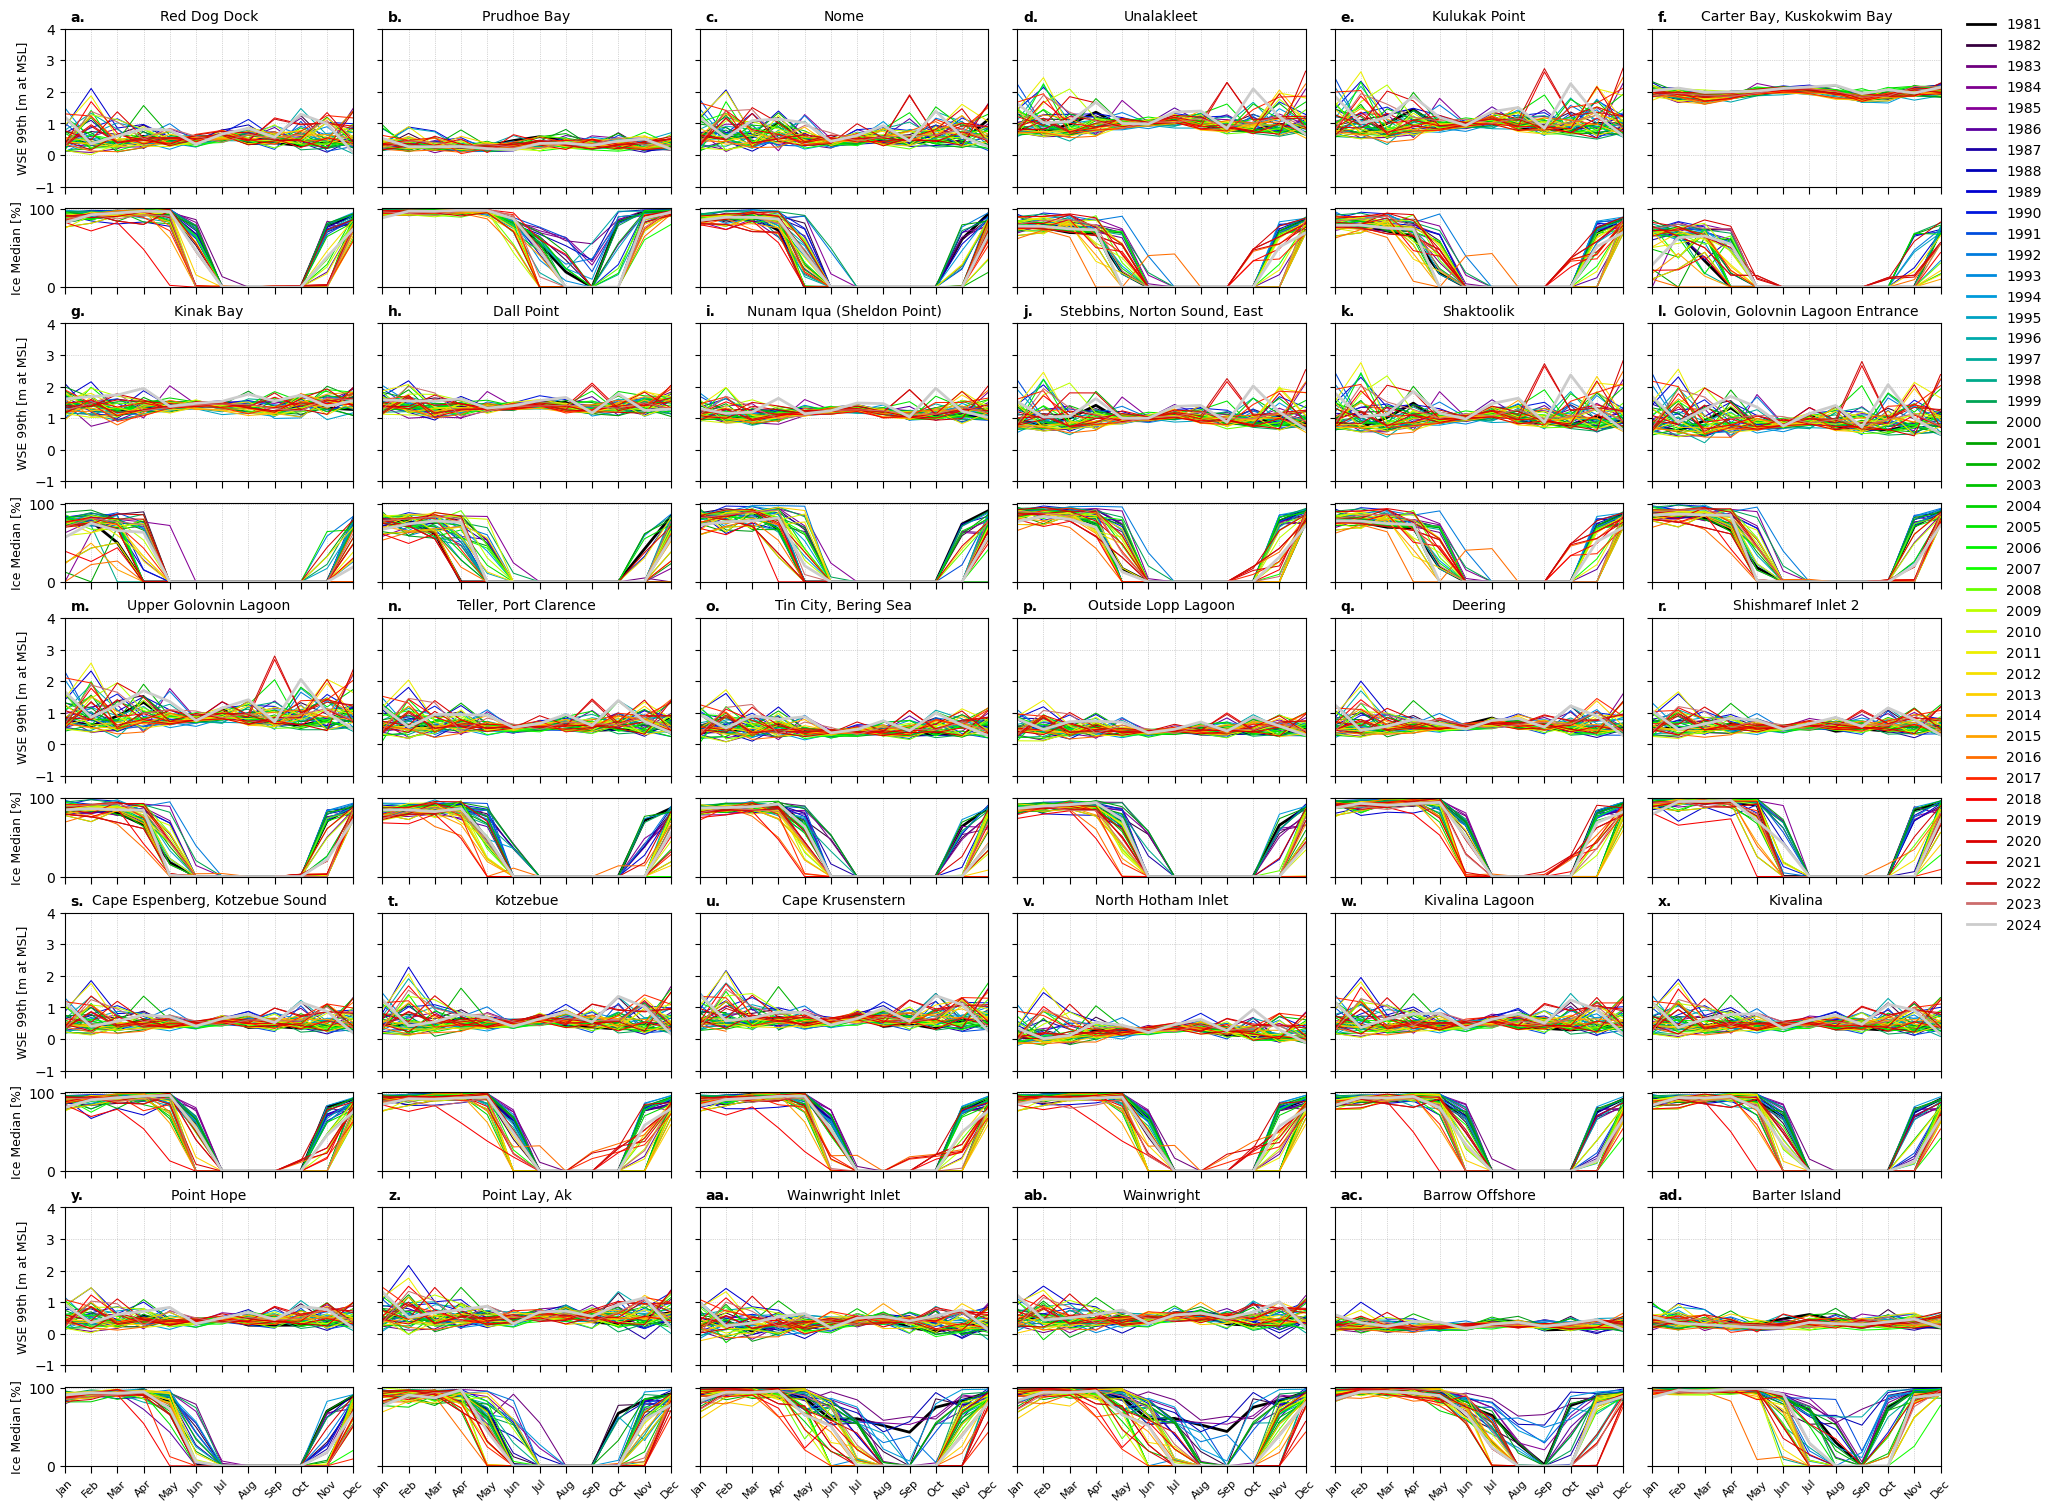

In [5]:
percentile_key = '99th'
percentile_key2 = '50th'
comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]

# subplot labels
# letters for subplot labels
letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
           'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
           'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
           'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.']
# Determine grid size: one column per station, two rows per station-group
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))

# Create figure with wave rows twice the height of ice rows
fig, axes = plt.subplots(
    nrows*2, ncols,
    figsize=(ncols*3.25, nrows*3),
    sharex=False,
    constrained_layout=True,
    gridspec_kw={'height_ratios': [2, 1] * nrows}
)

# Ensure axes is 2D
axes = np.atleast_2d(axes)

# Color map for years
cmap   = mpl.cm.get_cmap("nipy_spectral", len(years))
colors = {yr: cmap(i) for i, yr in enumerate(years)}

for idx, comm in enumerate(comms_ordered):
    row      = idx // ncols
    col      = idx % ncols
    ax_zeta  = axes[2*row,   col]
    ax_ice   = axes[2*row+1, col]
    comm_dict = monthly_data.get(comm, {})

    # Plot each year's median
    for yr in years:
        yr_dict = comm_dict.get(yr, {})
        months  = sorted(k for k in yr_dict.keys() if isinstance(k, int))
        #waves   = [yr_dict[m].get('zeta_max', np.nan)  for m in months]
        zeta   = [yr_dict[m]['zeta_percentiles'].get(percentile_key, np.nan) for m in months]
        ice     = [yr_dict[m]['iceaf_percentiles'].get(percentile_key2, np.nan) for m in months]
        lw = 2.0 if yr in (years[0], years[-1]) else 0.75

        if any(~np.isnan(zeta)):
            ax_zeta.plot(months, zeta, color=colors[yr], linewidth=lw)
        if any(~np.isnan(ice)):
            ax_ice .plot(months, ice,   color=colors[yr], linewidth=lw)

    # Format wave subplot
    ax_zeta.set_ylim(-1, 4)
    ax_zeta.set_xlim(1, 12)
    ax_zeta.set_title(f"{comm.title()}", fontsize=10)
    ax_zeta.set_xticks(range(1, 13))
    ax_zeta.set_xticklabels([])
    ax_zeta.tick_params(axis='x', length=5)
    if col == 0:
        ax_zeta.set_ylabel("WSE 99th [m at MSL]", fontsize=9)
    else:
        ax_zeta.set_yticklabels([])
    ax_zeta.grid(True, linestyle=':', linewidth=0.5)
    ax_zeta.text(0.02, 1.03, letters[idx],
                 transform=ax_zeta.transAxes,
                 fontsize=10, weight='bold', va='bottom')

    # Format ice subplot
    ax_ice.set_ylim(0, 101)
    ax_ice.set_xlim(1, 12)
    ax_ice.set_xticks(range(1, 13))
    if row == nrows - 1:
        ax_ice.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)],
                               rotation=45, fontsize=8)
    else:
        ax_ice.set_xticklabels([])
    ax_ice.tick_params(axis='x', length=5)
    if col == 0:
        ax_ice.set_ylabel("Ice Median [%]", fontsize=9)
    else:
        ax_ice.set_yticklabels([])

    ax_ice.grid(True, linestyle=':', linewidth=0.5)

# Hide unused subplots
for i in range(n, nrows * ncols):
    r = i // ncols
    c = i % ncols
    axes[2*r,   c].axis('off')
    axes[2*r+1, c].axis('off')

# Shared legend at top
handles = [mpl.lines.Line2D([0], [0], color=colors[yr], lw=2) for yr in years]
fig.legend(handles, years,
           loc='upper center', bbox_to_anchor=(1.025, 1.0),
           ncol=1, fontsize=10,frameon=False)

plt.savefig('/scratch/tmiesse/project/figures/seasonal_wl_ice_99.png',
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


/tmp/ipykernel_952176/274693262.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = mpl.cm.get_cmap("nipy_spectral", len(selected_years))


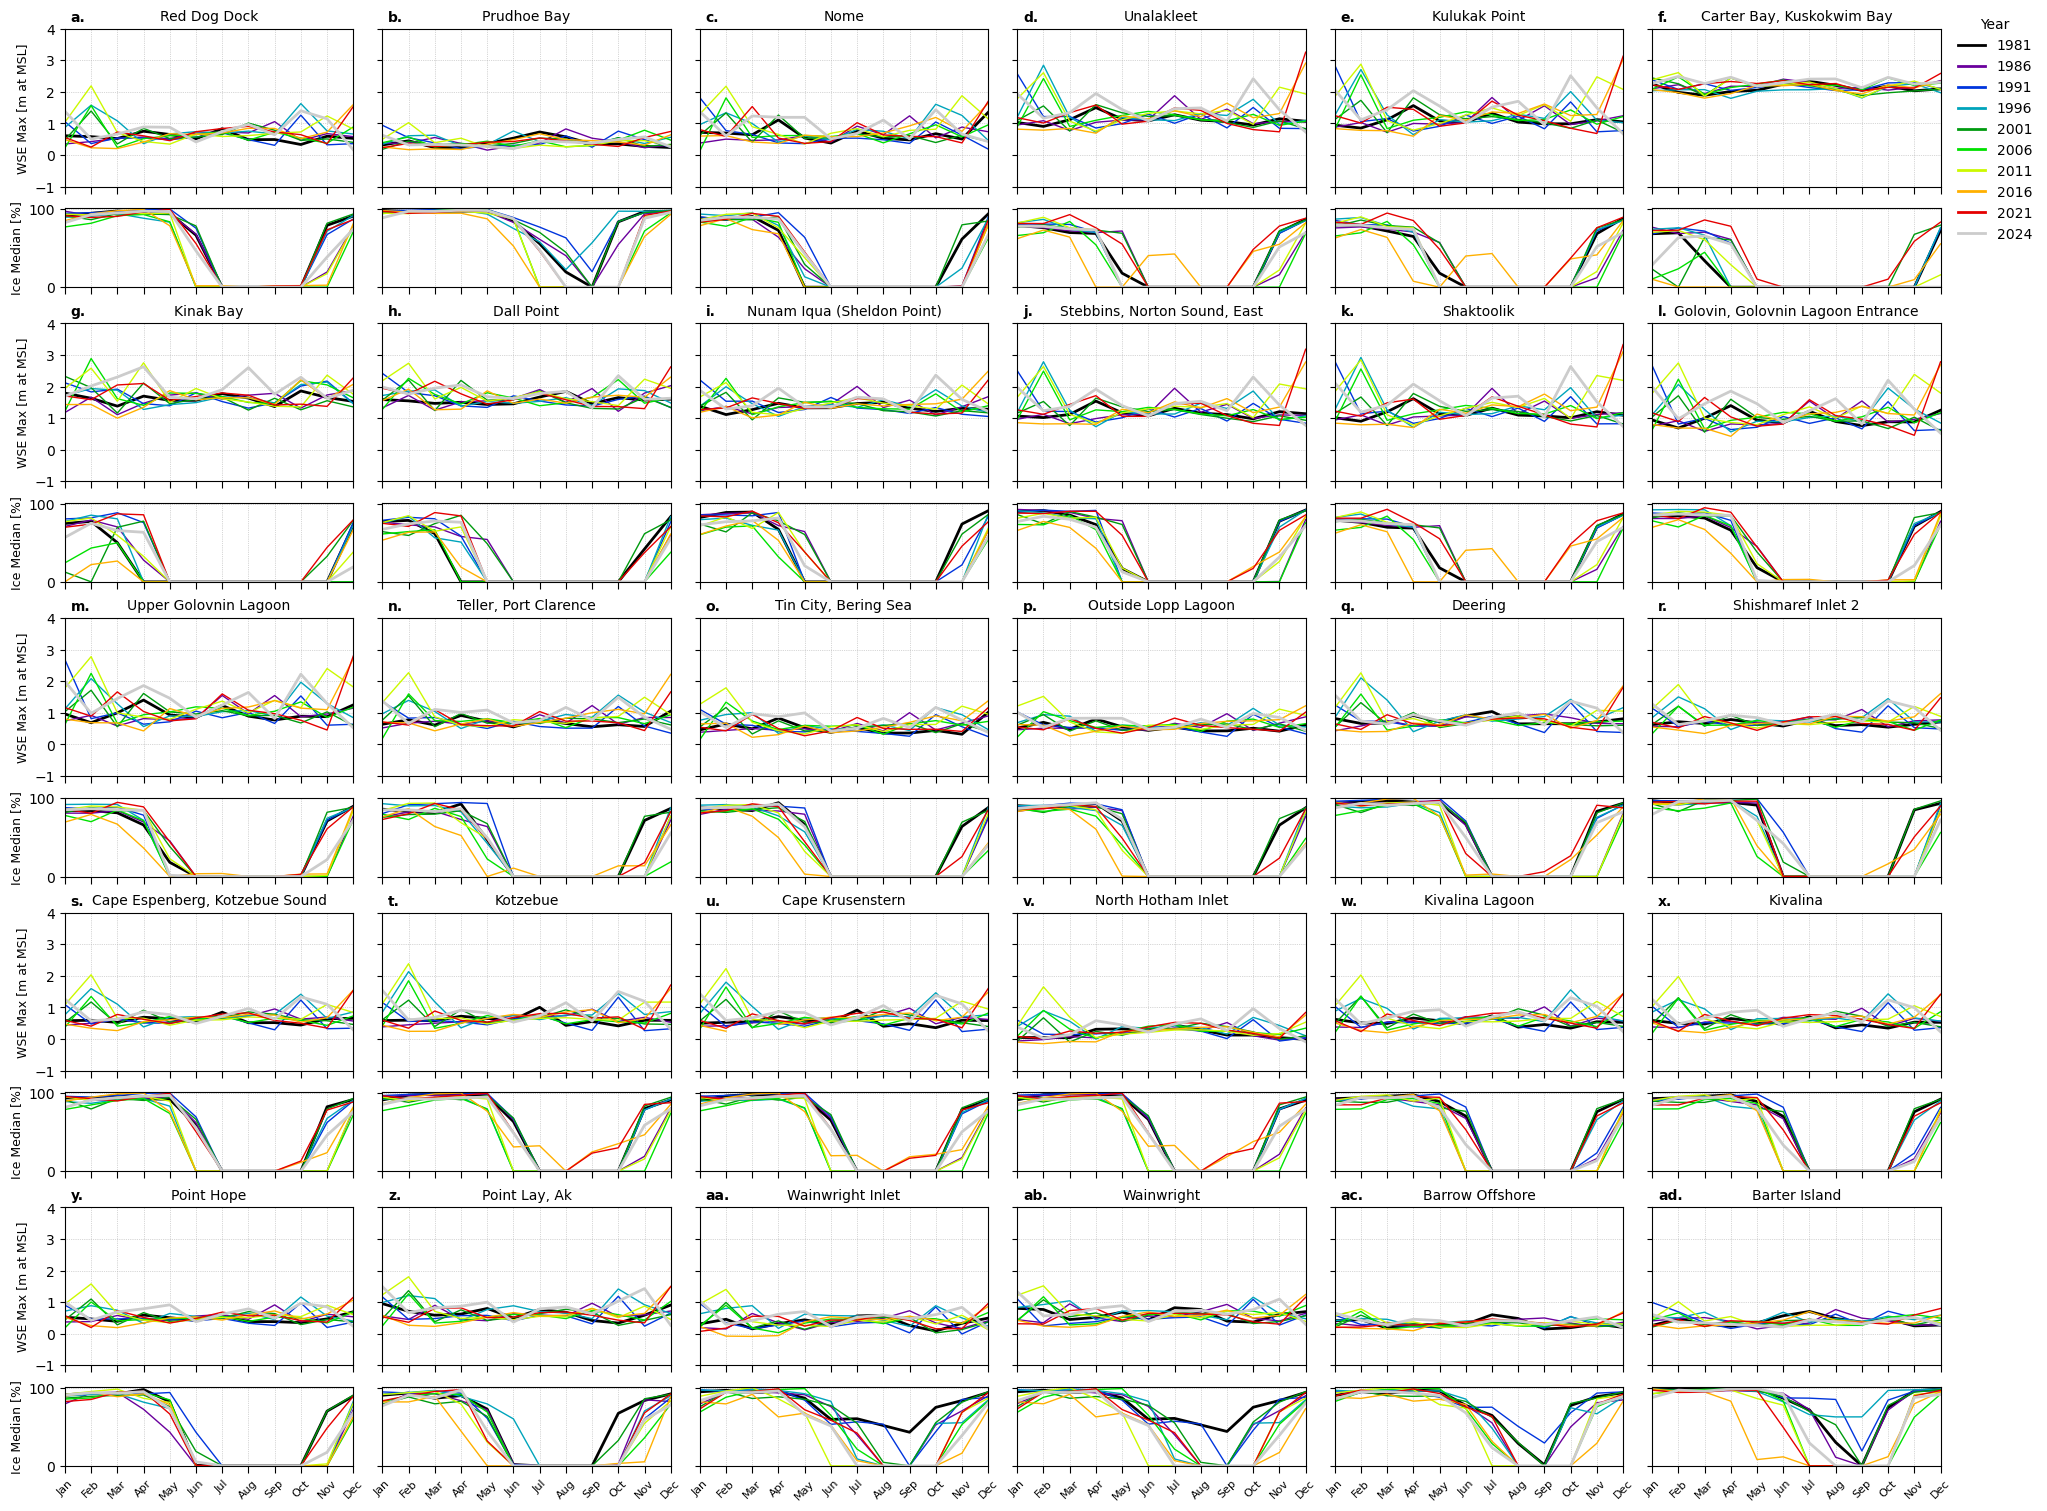

In [6]:
percentile_key  = '99th'
percentile_key2 = '50th'
comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]

# subplot labels
# letters for subplot labels
letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
           'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
           'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
           'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.']
# pick only every 5th year (including first and last)
year_ints       = [int(y) for y in years]
start_year      = year_ints[0]
selected_years  = {str(y) for y in year_ints if (y - start_year) % 5 == 0}
# ensure last year is included
selected_years.add(str(year_ints[-1]))

n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows*2, ncols,
    figsize=(ncols*3.25, nrows*3),
    sharex=False,
    constrained_layout=True,
    gridspec_kw={'height_ratios': [2, 1] * nrows}
)
axes = np.atleast_2d(axes)

cmap   = mpl.cm.get_cmap("nipy_spectral", len(selected_years))
# map only selected years to colors
colors = {yr: cmap(i) for i, yr in enumerate(sorted(selected_years))}

for idx, comm in enumerate(comms_ordered):
    row      = idx // ncols
    col      = idx % ncols
    ax_zeta  = axes[2*row,   col]
    ax_ice   = axes[2*row+1, col]
    comm_dict = monthly_data.get(comm, {})

    for yr in years:
        if str(yr) not in selected_years:
            continue
        yr_dict = comm_dict.get(str(yr), {})
        months  = sorted(k for k in yr_dict.keys() if isinstance(k, int))
        zeta   = [yr_dict[m].get('zeta_max', np.nan)  for m in months]
        #zeta    = [yr_dict[m]['zeta_percentiles'].get(percentile_key, np.nan) for m in months]
        ice     = [yr_dict[m]['iceaf_percentiles'].get(percentile_key2, np.nan) for m in months]
        lw      = 2.0 if yr in (years[0], years[-1]) else 1.0

        if any(~np.isnan(zeta)):
            ax_zeta.plot(months, zeta, color=colors[str(yr)], linewidth=lw)
        if any(~np.isnan(ice)):
            ax_ice .plot(months, ice,   color=colors[str(yr)], linewidth=lw)

    # wave subplot formatting
    ax_zeta.set_ylim(-1, 4)
    ax_zeta.set_xlim(1, 12)
    ax_zeta.set_title(f"{comm.title()}", fontsize=10)
    ax_zeta.set_xticks(range(1, 13))
    ax_zeta.set_xticklabels([])
    ax_zeta.tick_params(axis='x', length=5)
    if col == 0:
        ax_zeta.set_ylabel("WSE Max [m at MSL]", fontsize=9)
    else:
        ax_zeta.set_yticklabels([])
    ax_zeta.grid(True, linestyle=':', linewidth=0.5)
    ax_zeta.text(0.02, 1.03, letters[idx],
                 transform=ax_zeta.transAxes,
                 fontsize=10, weight='bold', va='bottom')

    # ice subplot formatting
    ax_ice.set_ylim(0, 101)
    ax_ice.set_xlim(1, 12)
    ax_ice.set_xticks(range(1, 13))
    if row == nrows - 1:
        ax_ice.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)],
                               rotation=45, fontsize=8)
    else:
        ax_ice.set_xticklabels([])
    ax_ice.tick_params(axis='x', length=5)
    if col == 0:
        ax_ice.set_ylabel("Ice Median [%]", fontsize=9)
    else:
        ax_ice.set_yticklabels([])
    ax_ice.grid(True, linestyle=':', linewidth=0.5)

# hide unused
for i in range(n, nrows * ncols):
    r, c = divmod(i, ncols)
    axes[2*r,   c].axis('off')
    axes[2*r+1, c].axis('off')

# legend for selected years
handles = [mpl.lines.Line2D([0], [0], color=colors[yr], lw=2) for yr in sorted(selected_years)]
fig.legend(handles, sorted(selected_years),
           title="Year",
           loc='upper center',
           bbox_to_anchor=(1.02, 1.0),
           ncol=1, fontsize=10, frameon=False)

plt.savefig('/scratch/tmiesse/project/figures/seasonal_wl_ice_max_every5yr.png',
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:103: SyntaxWarning: invalid escape sequence '\c'
<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:103: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_952176/847976866.py:90: SyntaxWarning: invalid escape sequence '\c'
  f"{lab} {m0*1000:.2f} $[mm \cdot yr^{{-1}}]$ (τ={tau0:.2f}, p={p0:.3f})"
/tmp/ipykernel_952176/847976866.py:103: SyntaxWarning: invalid escape sequence '\c'
  f"{lab} {m_p*1000:.2f} $[mm \cdot yr^{{-1}}]$ (τ={tau_p:.2f}, p={p_p:.3f})"


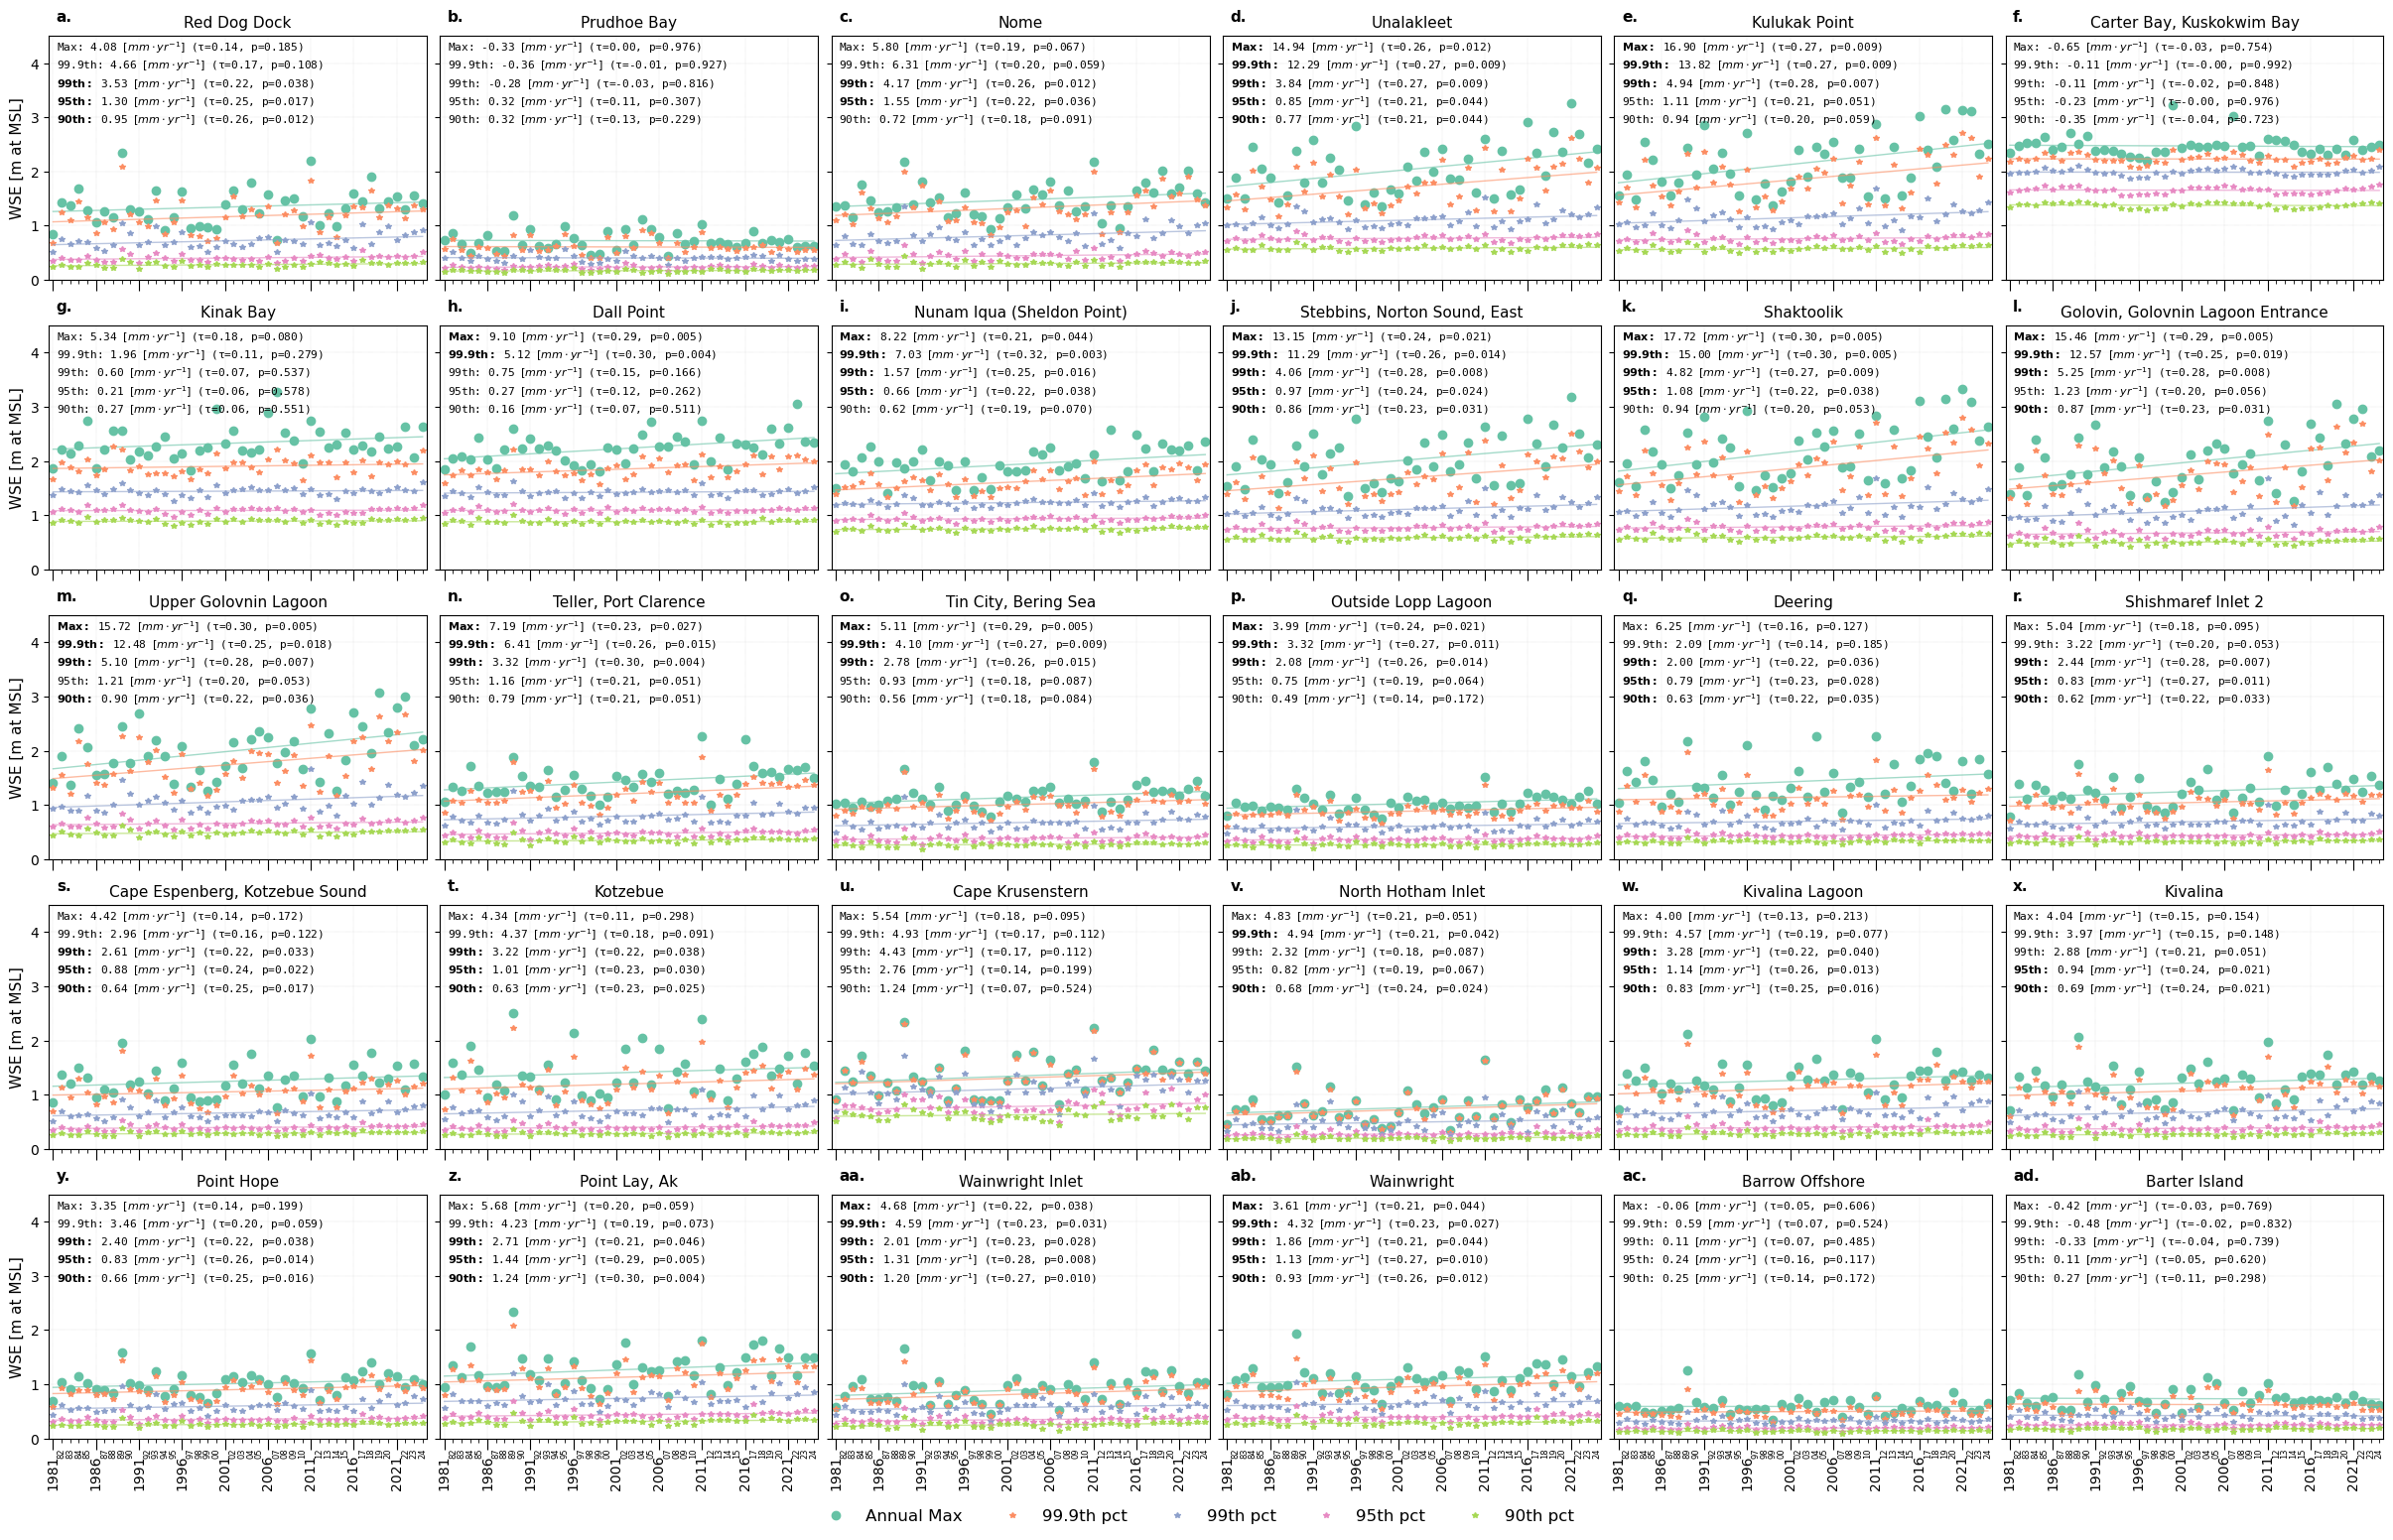

In [7]:
years_int = np.array([int(y) for y in years])
from matplotlib.ticker import FixedLocator, FuncFormatter
comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]

letters = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
           'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
           'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
           'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.']

percentile_keys = ['99.9th','99th','95th','90th']

# ─── assume 'years' (list of year strings) and 'monthly_data' dict are already defined ────────────

annual_max = {
    comm: np.array([monthly_data[comm][yr]['yearly_max_zeta'] for yr in years])
    for comm in comms_ordered
}
annual_pct = {
    comm: {
        pk: np.array([monthly_data[comm][yr]['zeta_annual_percentiles'][pk] for yr in years])
        for pk in percentile_keys
    }
    for comm in comms_ordered
}

# ─── set up figure with constrained_layout ───────────────────────────────────────
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True,
                         constrained_layout=True)
axes = axes.flatten()

cmap       = plt.get_cmap('Set2')
max_color  = cmap(0)
pct_colors = {'99.9th': cmap(1),'99th': cmap(2), '95th': cmap(3), '90th': cmap(4)}

for idx, comm in enumerate(comms_ordered):
    ax = axes[idx]
    zmax = annual_max[comm]

    # plot annual max + linear fit
    ax.plot(years_int, zmax, 'o', color=max_color, lw=1.5, markersize=6, label='Annual Max')
    valid = ~np.isnan(zmax)
    if valid.sum() >= 2:
        # plot the OLS line
        m0, b0 = np.polyfit(years_int[valid], zmax[valid], 1)
        ax.plot(years_int, b0 + m0*years_int, '-', color=max_color, alpha=0.6, lw=1)

        # Mann–Kendall test
        mk0 = mk.original_test(zmax[valid])
        p0  = mk0.p       # p-value
        tau0 = mk0.Tau    # Kendall's τ

    # plot percentiles + trends
    rates = []
    for pk in percentile_keys:
        arr = annual_pct[comm][pk]
        ax.plot(years_int, arr, '*', color=pct_colors[pk], markersize=4, label=f'{pk} pct')
        vm = ~np.isnan(arr)
        if vm.sum() >= 2:
            m_p, b_p = np.polyfit(years_int[vm], arr[vm], 1)
            ax.plot(years_int, b_p + m_p*years_int, '-', color=pct_colors[pk], alpha=0.6, lw=1)

            mk_p = mk.original_test(arr[vm])
            p_p  = mk_p.p
            tau_p = mk_p.Tau
            rates.append((pk, m_p, p_p, tau_p))

    # build annotation text (with MK p-values & τ)
    lines = []
    if valid.sum() >= 2:
        # build the label, bold if significant
        lab = "Max:"
        if p0 < 0.05:
            lab = r"$\mathbf{Max:}$"
        lines.append(
            f"{lab} {m0*1000:.2f} $[mm \cdot yr^{{-1}}]$ (τ={tau0:.2f}, p={p0:.3f})"
        )

    # percentiles
    for pk, m_p, p_p, tau_p in rates:
        # raw label (e.g. "99.9th:")
        raw = f"{pk}:"
        # if p<0.05, bold it
        if p_p < 0.05:
            lab = rf"$\mathbf{{{raw}}}$"
        else:
            lab = raw
        lines.append(
            f"{lab} {m_p*1000:.2f} $[mm \cdot yr^{{-1}}]$ (τ={tau_p:.2f}, p={p_p:.3f})"
        )

    text = "\n".join(lines)
    ax.text(0.02, 0.985, text,
            transform=ax.transAxes,
            family='monospace', size=8,
            va='top', clip_on=False)

    # formatting (same as before)...
    ax.set_title(comm.title(), fontsize=11)
    ax.set_xlim(years_int.min() - 0.5, years_int.max() + 0.5)
    major = years_int[::5]; minor = years_int
    ax.xaxis.set_major_locator(FixedLocator(major))
    ax.xaxis.set_minor_locator(FixedLocator(minor))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    ax.xaxis.set_minor_formatter(FuncFormatter(lambda x, pos: f"{int(x)%100:02d}"))
    ax.tick_params(axis='x', which='major', rotation=90, labelsize=10, length=8)
    ax.tick_params(axis='x', which='minor', rotation=90, labelsize=6, length=3)

    ax.set_ylim(0, 4.5)
    ax.grid(True, linestyle=':', linewidth=0.25)
    if idx % ncols == 0:
        ax.set_ylabel("WSE [m at MSL]", fontsize=11)
    else:
        ax.tick_params(labelleft=False)
    ax.text(0.02, 1.06, letters[idx], transform=ax.transAxes,
            fontsize=11, weight='bold', clip_on=False)

# turn off extra axes
for ax in axes[n:]:
    ax.axis('off')

# shared legend
h, l = axes[0].get_legend_handles_labels()
fig.legend(h, l, loc="upper center", ncol=5,
           bbox_to_anchor=(0.5, 0.0), fontsize=12, frameon=False)

# save & show
fig.savefig('/scratch/tmiesse/project/figures/annual_trends_mk2.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1)
plt.show()

/tmp/ipykernel_952176/4039277390.py:68: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_kpss = kpss(arr, regression='c', nlags='auto')[1]
/tmp/ipykernel_952176/4039277390.py:68: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_kpss = kpss(arr, regression='c', nlags='auto')[1]
/tmp/ipykernel_952176/4039277390.py:68: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_kpss = kpss(arr, regression='c', nlags='auto')[1]
/tmp/ipykernel_952176/4039277390.py:68: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_kpss =

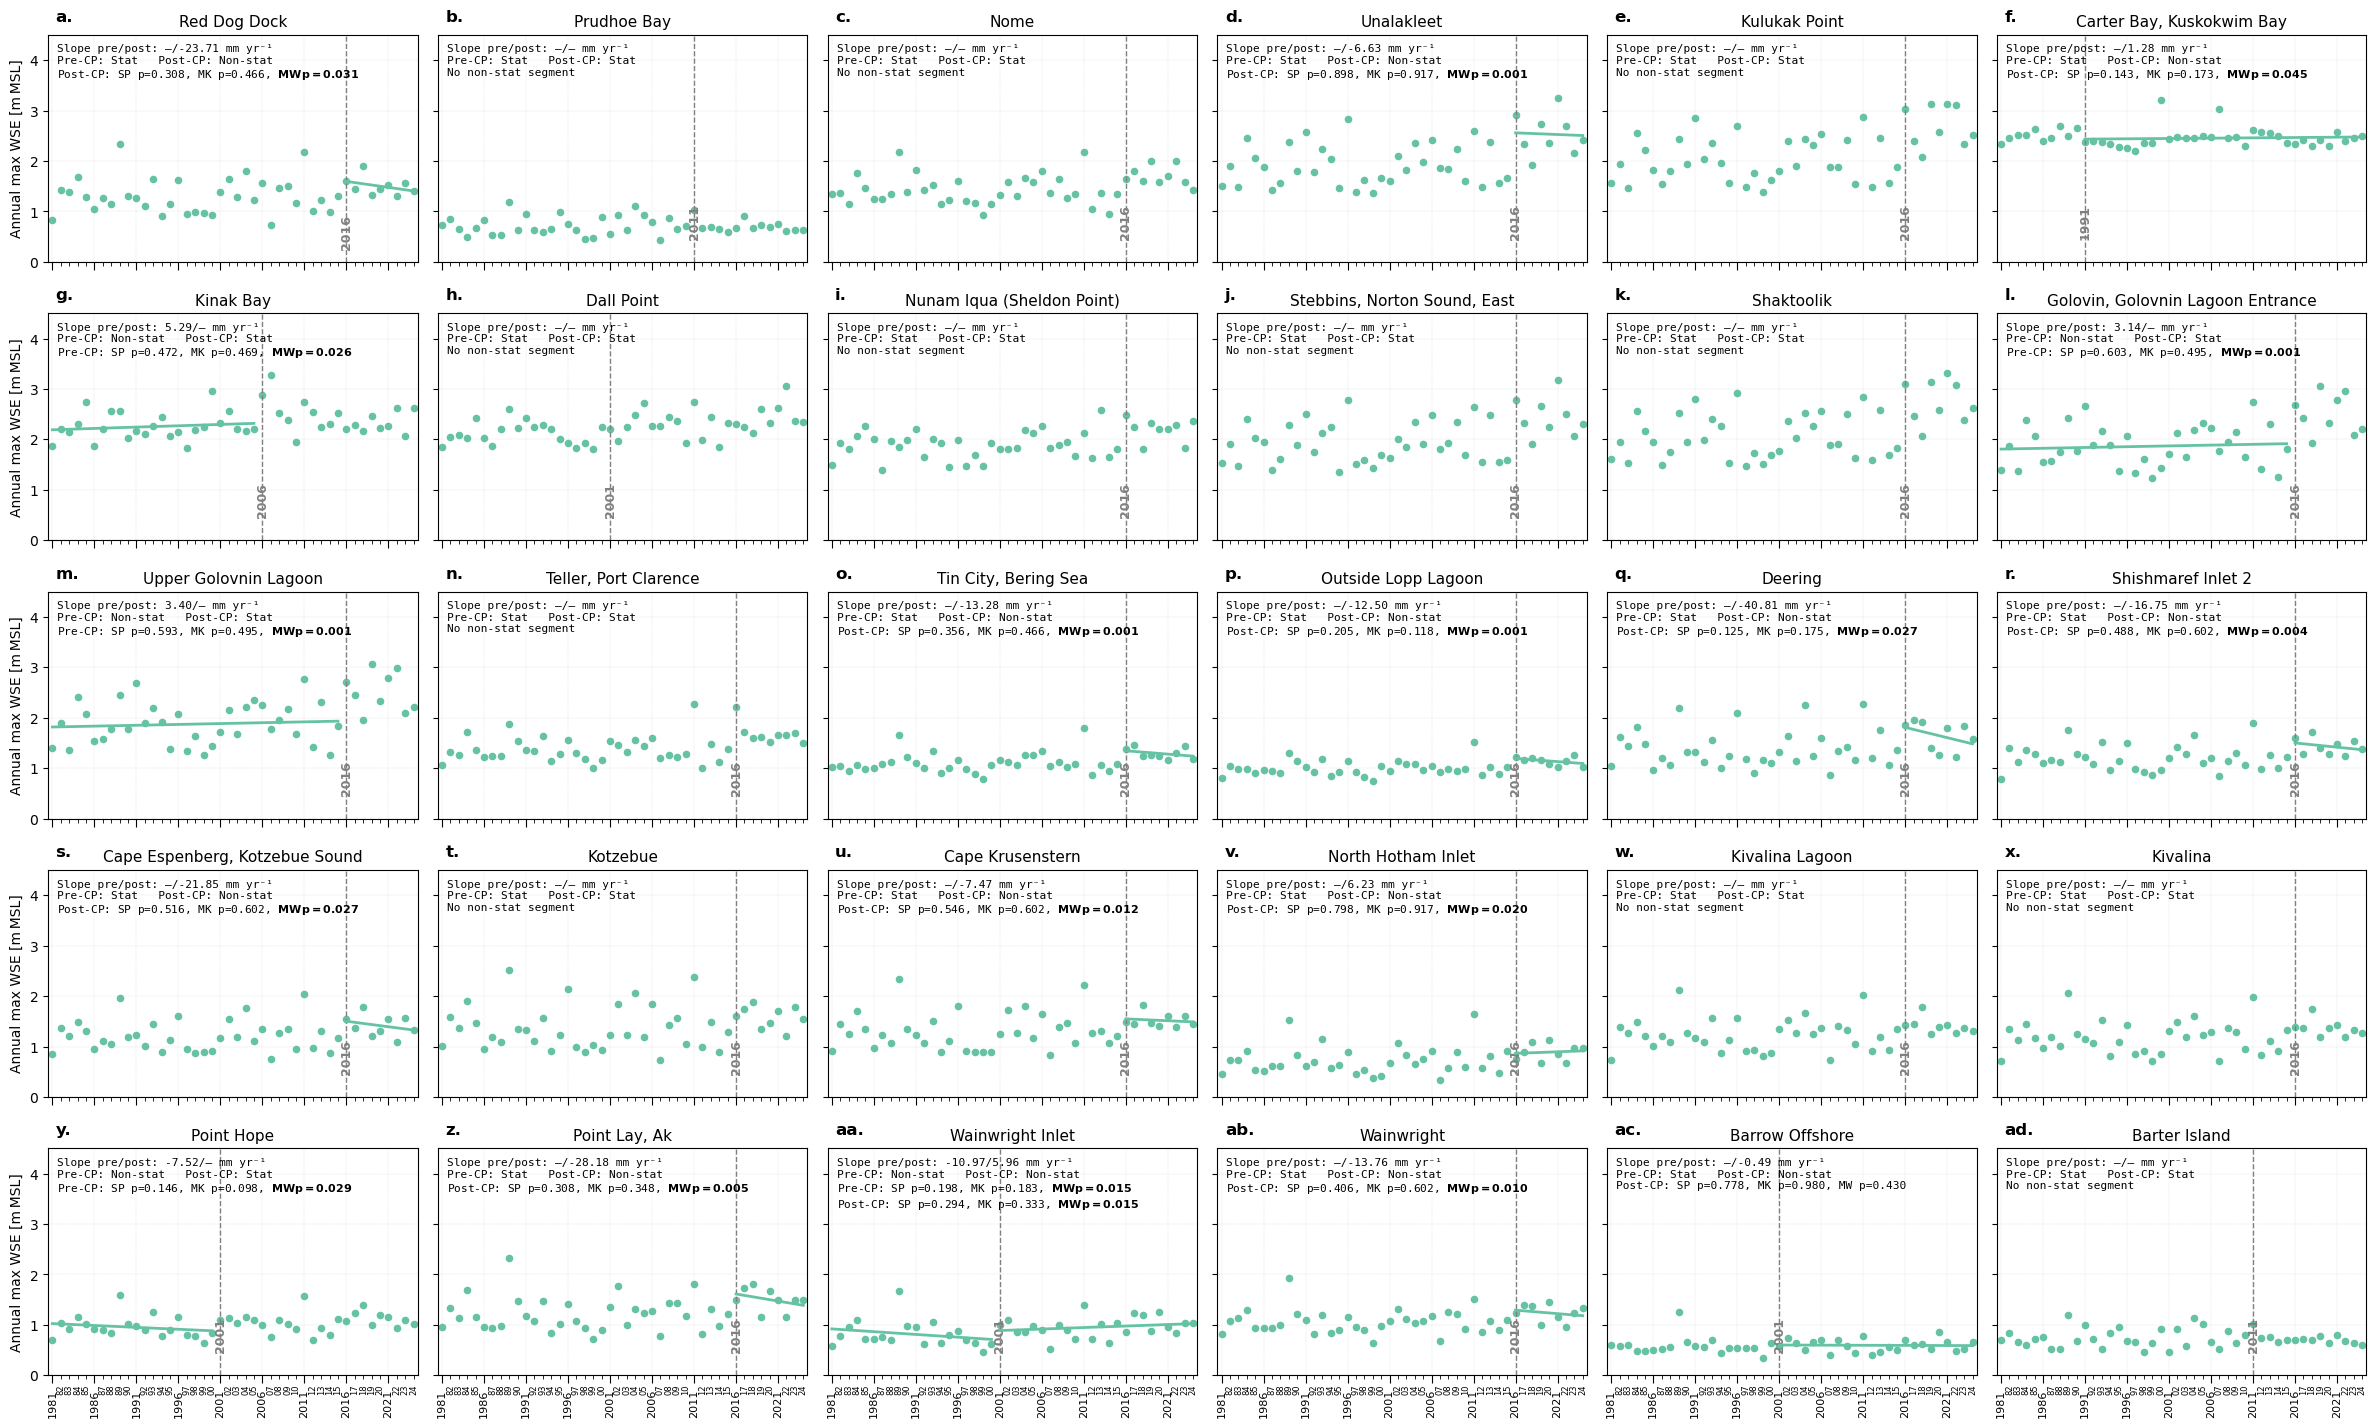

In [8]:
import ruptures as rpt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import mannwhitneyu, spearmanr
import pymannkendall as mk
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FixedLocator, FuncFormatter

years_int = np.array([int(y) for y in years])
cmap      = plt.get_cmap('Set2')
max_color = cmap(0)
alpha     = 0.05  # stationarity threshold

# build annual_max dict
annual_max = {
    comm: np.array([monthly_data[comm][yr]['yearly_max_zeta'] for yr in years])
    for comm in comms_ordered
}

# set up grid
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True, sharey=True,
                         constrained_layout=False)
axes = axes.flatten()

for idx, comm in enumerate(comms_ordered):
    ax    = axes[idx]
    y_all = annual_max[comm]
    mask  = ~np.isnan(y_all)
    x     = years_int[mask]
    y     = y_all[mask]

    if len(x) < 2:
        ax.text(0.5, 0.5, "Insufficient data", transform=ax.transAxes,
                ha='center', va='center')
        ax.set_title(comm.title(), fontsize=11)
        ax.text(0.02, 1.06, letters[idx], transform=ax.transAxes,
                fontsize=12, weight='bold', clip_on=False)
        continue

    # 1) scatter
    ax.scatter(x, y, s=20, color=max_color, zorder=2)

    # 2) change‐point
    algo   = rpt.Binseg(model="rbf").fit(y.reshape(-1,1))
    bkps   = algo.predict(n_bkps=1)
    cp_idx = bkps[0]
    has_cp = 0 < cp_idx < len(y)
    if has_cp:
        cp_year = x[cp_idx]
        ax.axvline(cp_year, color='gray', linestyle='--', linewidth=1)
        y_top = ax.get_ylim()[1]*0.1
        ax.text(cp_year, y_top, f"{cp_year}",
                color='gray', fontsize=9, weight='bold',
                ha='center', va='bottom', rotation=90, clip_on=False)

    # split
    x_pre,  y_pre  = x[:cp_idx], y[:cp_idx]
    x_post, y_post = x[cp_idx:], y[cp_idx:]

    # helper: is stationary?
    def is_stat(arr):
        try:
            p_adf  = adfuller(arr, autolag='AIC')[1]
            p_kpss = kpss(arr, regression='c', nlags='auto')[1]
            return (p_adf < alpha) and (p_kpss > alpha)
        except:
            return False

    # trend‐test helper
    def trend_tests(xa, ya):
        rho, p_sp = spearmanr(xa, ya)
        mk_res    = mk.original_test(ya)
        return p_sp, mk_res.Tau, mk_res.p

    # global MWU
    if has_cp and len(y_pre)>=1 and len(y_post)>=1:
        _, p_mwu = mannwhitneyu(y_pre, y_post, alternative='two-sided')
    else:
        p_mwu = np.nan

    # compute only on _non‐stationary_ segments
    pre_nstat  = len(x_pre)>=3  and not is_stat(y_pre)
    post_nstat = has_cp and len(x_post)>=3 and not is_stat(y_post)

    if pre_nstat:
        m1, b1         = np.polyfit(x_pre, y_pre, 1)
        slope_pre      = m1*1000
        p_sp1, tau1, p_mk1 = trend_tests(x_pre, y_pre)
        ax.plot(x_pre, b1 + m1*x_pre, color=max_color, linewidth=2, zorder=3)
    if post_nstat:
        m2, b2         = np.polyfit(x_post, y_post, 1)
        slope_post     = m2*1000
        p_sp2, tau2, p_mk2 = trend_tests(x_post, y_post)
        ax.plot(x_post, b2 + m2*x_post, color=max_color, linewidth=2, zorder=3)

    # build annotation:
    # 1) slopes
    sp_pre  = f"{slope_pre:.2f}" if pre_nstat else "—"
    sp_post = f"{slope_post:.2f}" if post_nstat else "—"
    slope_line = f"Slope pre/post: {sp_pre}/{sp_post} mm yr⁻¹"

    # 2) stationarity status
    stat_line = (f"Pre‑CP: {'Non‑stat' if pre_nstat else 'Stat'}"
                 f"   Post‑CP: {'Non‑stat' if post_nstat else 'Stat'}")

    # 3) significance tests
    sig_lines = []
    if pre_nstat:
        sp1 = f"SP p={p_sp1:.3f}"
        if p_sp1 < alpha: sp1 = rf"$\mathbf{{{sp1}}}$"
        mk1 = f"MK p={p_mk1:.3f}"
        if p_mk1 < alpha: mk1 = rf"$\mathbf{{{mk1}}}$"
        mw1 = f"MW p={p_mwu:.3f}"
        if p_mwu<alpha: mw1 = rf"$\mathbf{{{mw1}}}$"
        sig_lines.append(f"Pre‑CP: {sp1}, {mk1}, {mw1}")
    if post_nstat:
        sp2 = f"SP p={p_sp2:.3f}"
        if p_sp2 < alpha: sp2 = rf"$\mathbf{{{sp2}}}$"
        mk2 = f"MK p={p_mk2:.3f}"
        if p_mk2 < alpha: mk2 = rf"$\mathbf{{{mk2}}}$"
        mw2 = f"MW p={p_mwu:.3f}"
        if p_mwu<alpha: mw2 = rf"$\mathbf{{{mw2}}}$"
        sig_lines.append(f"Post‑CP: {sp2}, {mk2}, {mw2}")
    if not sig_lines:
        sig_lines = ["No non‑stat segment"]

    # add anchored text
    text = "\n".join([slope_line, stat_line] + sig_lines)
    at = AnchoredText(text, loc='upper left',
                      prop=dict(family='monospace', size=8),
                      pad=0.3, frameon=False)
    ax.add_artist(at)

    # axis formatting
    ax.set_title(comm.title(), fontsize=11)
    ax.set_xlim(x.min()-0.5, x.max()+0.5)
    majors = years_int[::5]
    ax.xaxis.set_major_locator(FixedLocator(majors))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda t,pos: f"{int(t)}"))
    ax.xaxis.set_minor_locator(FixedLocator(years_int))
    ax.xaxis.set_minor_formatter(FuncFormatter(lambda t,pos: f"{int(t)%100:02d}"))
    ax.tick_params(axis='x', which='major', rotation=90, labelsize=8, length=6)
    ax.tick_params(axis='x', which='minor', rotation=90, labelsize=6, length=3)
    ax.set_ylim(0, 4.5)
    ax.grid(True, linestyle=':', linewidth=0.25)
    if idx % ncols == 0:
        ax.set_ylabel("Annual max WSE [m MSL]", fontsize=10)
    else:
        ax.tick_params(labelleft=False)

    ax.text(0.02, 1.06, letters[idx], transform=ax.transAxes,
            fontsize=12, weight='bold', clip_on=False)

# hide extras
for ax in axes[n:]:
    ax.axis('off')

# tighten spacing
plt.subplots_adjust(left=0.05, right=0.99,
                    top=0.96, bottom=0.04,
                    wspace=0.02, hspace=0.04)
plt.tight_layout(rect=[0,0.03,1,0.99])

plt.savefig(
    '/scratch/tmiesse/project/figures/annual_trends_nonstat_only.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1
)
plt.show()

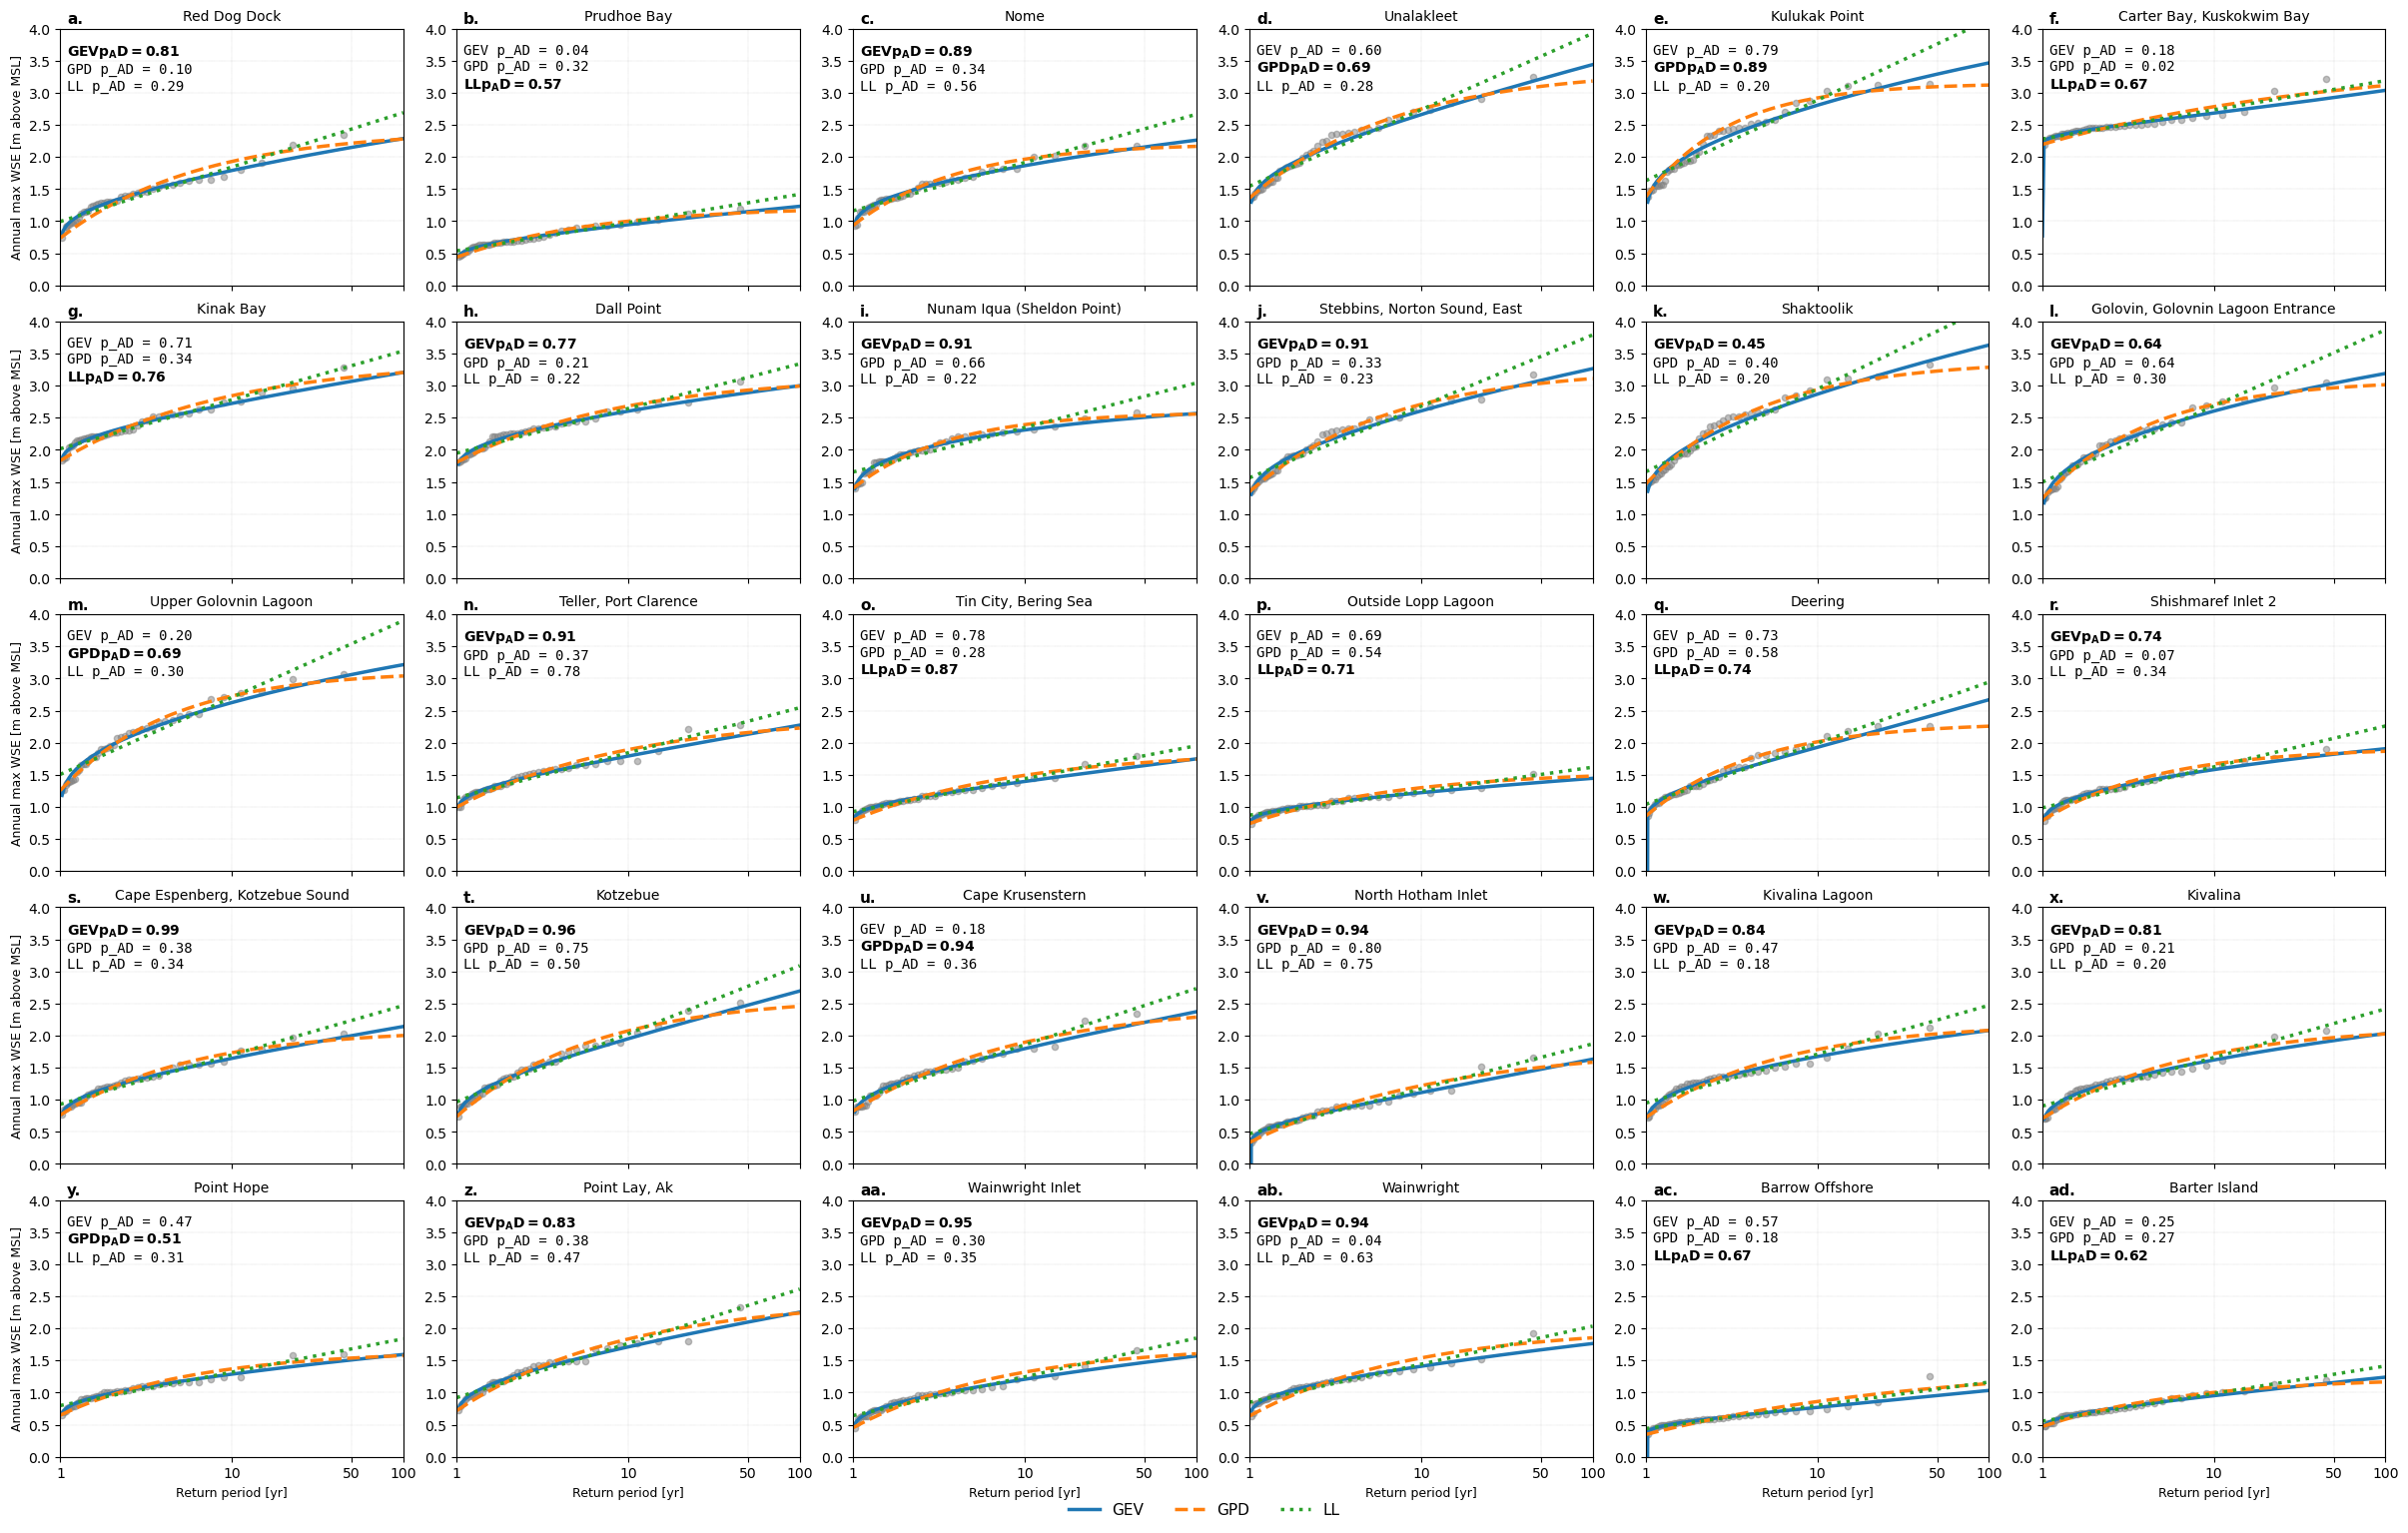

In [9]:
from scipy.stats import genpareto, genextreme, anderson_ksamp, PermutationMethod
from matplotlib.ticker import FixedLocator, FuncFormatter

# ─── assume years_int, comms_ordered, and annual_max are already defined ─────────
# years_int: np.array of years
# comms_ordered: list of station names
# annual_max: dict mapping station → 1D np.array of annual maxima
letters = [
    'a.','b.','c.','d.','e.','f.','g.','h.','i.','j.',
    'k.','l.','m.','n.','o.','p.','q.','r.','s.','t.',
    'u.','v.','w.','x.','y.','z.','aa.','ab.','ac.','ad.',
    'ae.','af.','ag.','ah.','ai.','aj.','ak.','al.','am.','an.'
]

# determine a global y‐limit
all_max = [
    d.max()
    for c in comms_ordered
    for d in [annual_max[c][~np.isnan(annual_max[c])]]
    if d.size
]
ymax = 4.#max(all_max) * 1.05

# return‐period grid up to 100 years
T_plot = np.logspace(0, math.log10(100), 200)

# prepare subplots
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True,
                         constrained_layout=True)
axes = axes.flatten()

c_gev, c_gpd, c_ll = 'C0','C1','C2'

for idx, comm in enumerate(comms_ordered):
    ax   = axes[idx]
    data = annual_max[comm]
    data = data[~np.isnan(data)]
    if data.size < 3:
        ax.set_title(comm.title(), fontsize=10)
        ax.axis('off')
        continue

    # empirical points
    sorted_vals = np.sort(data)[::-1]
    N           = len(sorted_vals)
    ranks       = np.arange(1, N+1)
    T_emp       = (N + 1)/ranks

    # ─── GEV fit & AD ───────────────────────────────────────────────────────────
    c, loc, scale = genextreme.fit(sorted_vals)
    gev_cdf_vals  = genextreme.cdf(sorted_vals, c, loc=loc, scale=scale)
    ad_gev = anderson_ksamp(
        [gev_cdf_vals, np.random.rand(N)],
        method=PermutationMethod()
    )
    p_ad_gev = ad_gev.pvalue
    gev_curve     = genextreme.ppf(1 - 1/T_plot, c, loc=loc, scale=scale)

    # ─── GPD fit & AD ───────────────────────────────────────────────────────────
    thresh        = sorted_vals.min()
    excess        = sorted_vals - thresh
    c2, loc2, sc2 = genpareto.fit(excess, floc=0)
    gpd_cdf_vals  = genpareto.cdf(excess, c2, loc=0, scale=sc2)
    ad_gpd = anderson_ksamp(
        [gpd_cdf_vals, np.random.rand(N)],
        method=PermutationMethod()
    )
    p_ad_gpd = ad_gpd.pvalue
    gpd_curve     = thresh + genpareto.ppf(1 - 1/T_plot, c2, loc=0, scale=sc2)

    # ─── Log‑Linear fit & AD ────────────────────────────────────────────────────
    a, b       = np.polyfit(np.log(T_emp), sorted_vals, 1)
    pred_ll    = a*np.log(T_emp) + b
    ad_ll = anderson_ksamp(
        [sorted_vals, pred_ll],
        method=PermutationMethod()
    )
    p_ad_ll = ad_ll.pvalue
    ll_curve   = a*np.log(T_plot) + b

    # determine highest p‐value
    p_vals = {'GEV': p_ad_gev, 'GPD': p_ad_gpd, 'LL': p_ad_ll}
    max_p   = max(p_vals.values())

    # ─── plotting ──────────────────────────────────────────────────────────────
    ax.plot(T_plot, gev_curve, '-',  color=c_gev, label='GEV',lw=2.5)   
    ax.plot(T_plot, gpd_curve, '--', color=c_gpd, label='GPD', lw=2.5)
    ax.plot(T_plot, ll_curve,  ':',  color=c_ll,  label='LL', lw=2.5)
    ax.scatter(T_emp, sorted_vals, s=20, color='gray', alpha=0.5)

    ax.set_xscale('log')
    ax.set_xlim(1, 100)
    ax.set_ylim(0, ymax)

    # custom ticks at 1,10,50,100
    xticks = [1, 10, 50, 100]
    ax.xaxis.set_major_locator(FixedLocator(xticks))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
    ax.xaxis.set_minor_locator(FixedLocator([]))

    # ─── annotate AD p‐values, bold highest ───────────────────────────────────
    parts = []
    for name, p in p_vals.items():
        txt = f"{name} p_AD = {p:.2f}"
        if math.isclose(p, max_p, rel_tol=1e-6):
            txt = rf"$\mathbf{{{txt}}}$"
        parts.append(txt)
    ax.text(0.02, 0.75, "\n".join(parts),
            transform=ax.transAxes,
            family='monospace', size=10,
            va='bottom', ha='left',
            #bbox=dict(facecolor='white', alpha=0.7, pad=2),
            clip_on=False)

    # titles & labels
    ax.set_title(comm.title(), fontsize=10)
    if idx % ncols == 0:
        ax.set_ylabel("Annual max WSE [m above MSL]", fontsize=9)
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Return period [yr]", fontsize=9)

    ax.text(0.02, 1.02, letters[idx],
            transform=ax.transAxes,
            fontsize=11, weight='bold', clip_on=False)
    ax.grid(True, linestyle=':', linewidth=0.3, which='both')

# hide unused panels
for ax in axes[n:]:
    ax.axis('off')

# shared legend
fig.legend(
    ['GEV','GPD','LL'],
    loc='upper center', ncol=3,
    fontsize=11, frameon=False,
    bbox_to_anchor=(0.5,0.01)
)

plt.savefig(
    '/scratch/tmiesse/project/figures/return_periods_ad_bold_100yr.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1
)
plt.show()

/tmp/ipykernel_952176/2601313756.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_kpss = kpss(arr, regression='c', nlags='auto')[1]
/home/tmiesse/miniforge3/envs/general/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_952176/2601313756.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_kpss = kpss(arr, regression='c', nlags='auto')[1]
/tmp/ipykernel_952176/2601313756.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  p_kpss = kpss(arr, regression='c', nlags='auto')[1]
/tmp/ipykernel_952176/2601313

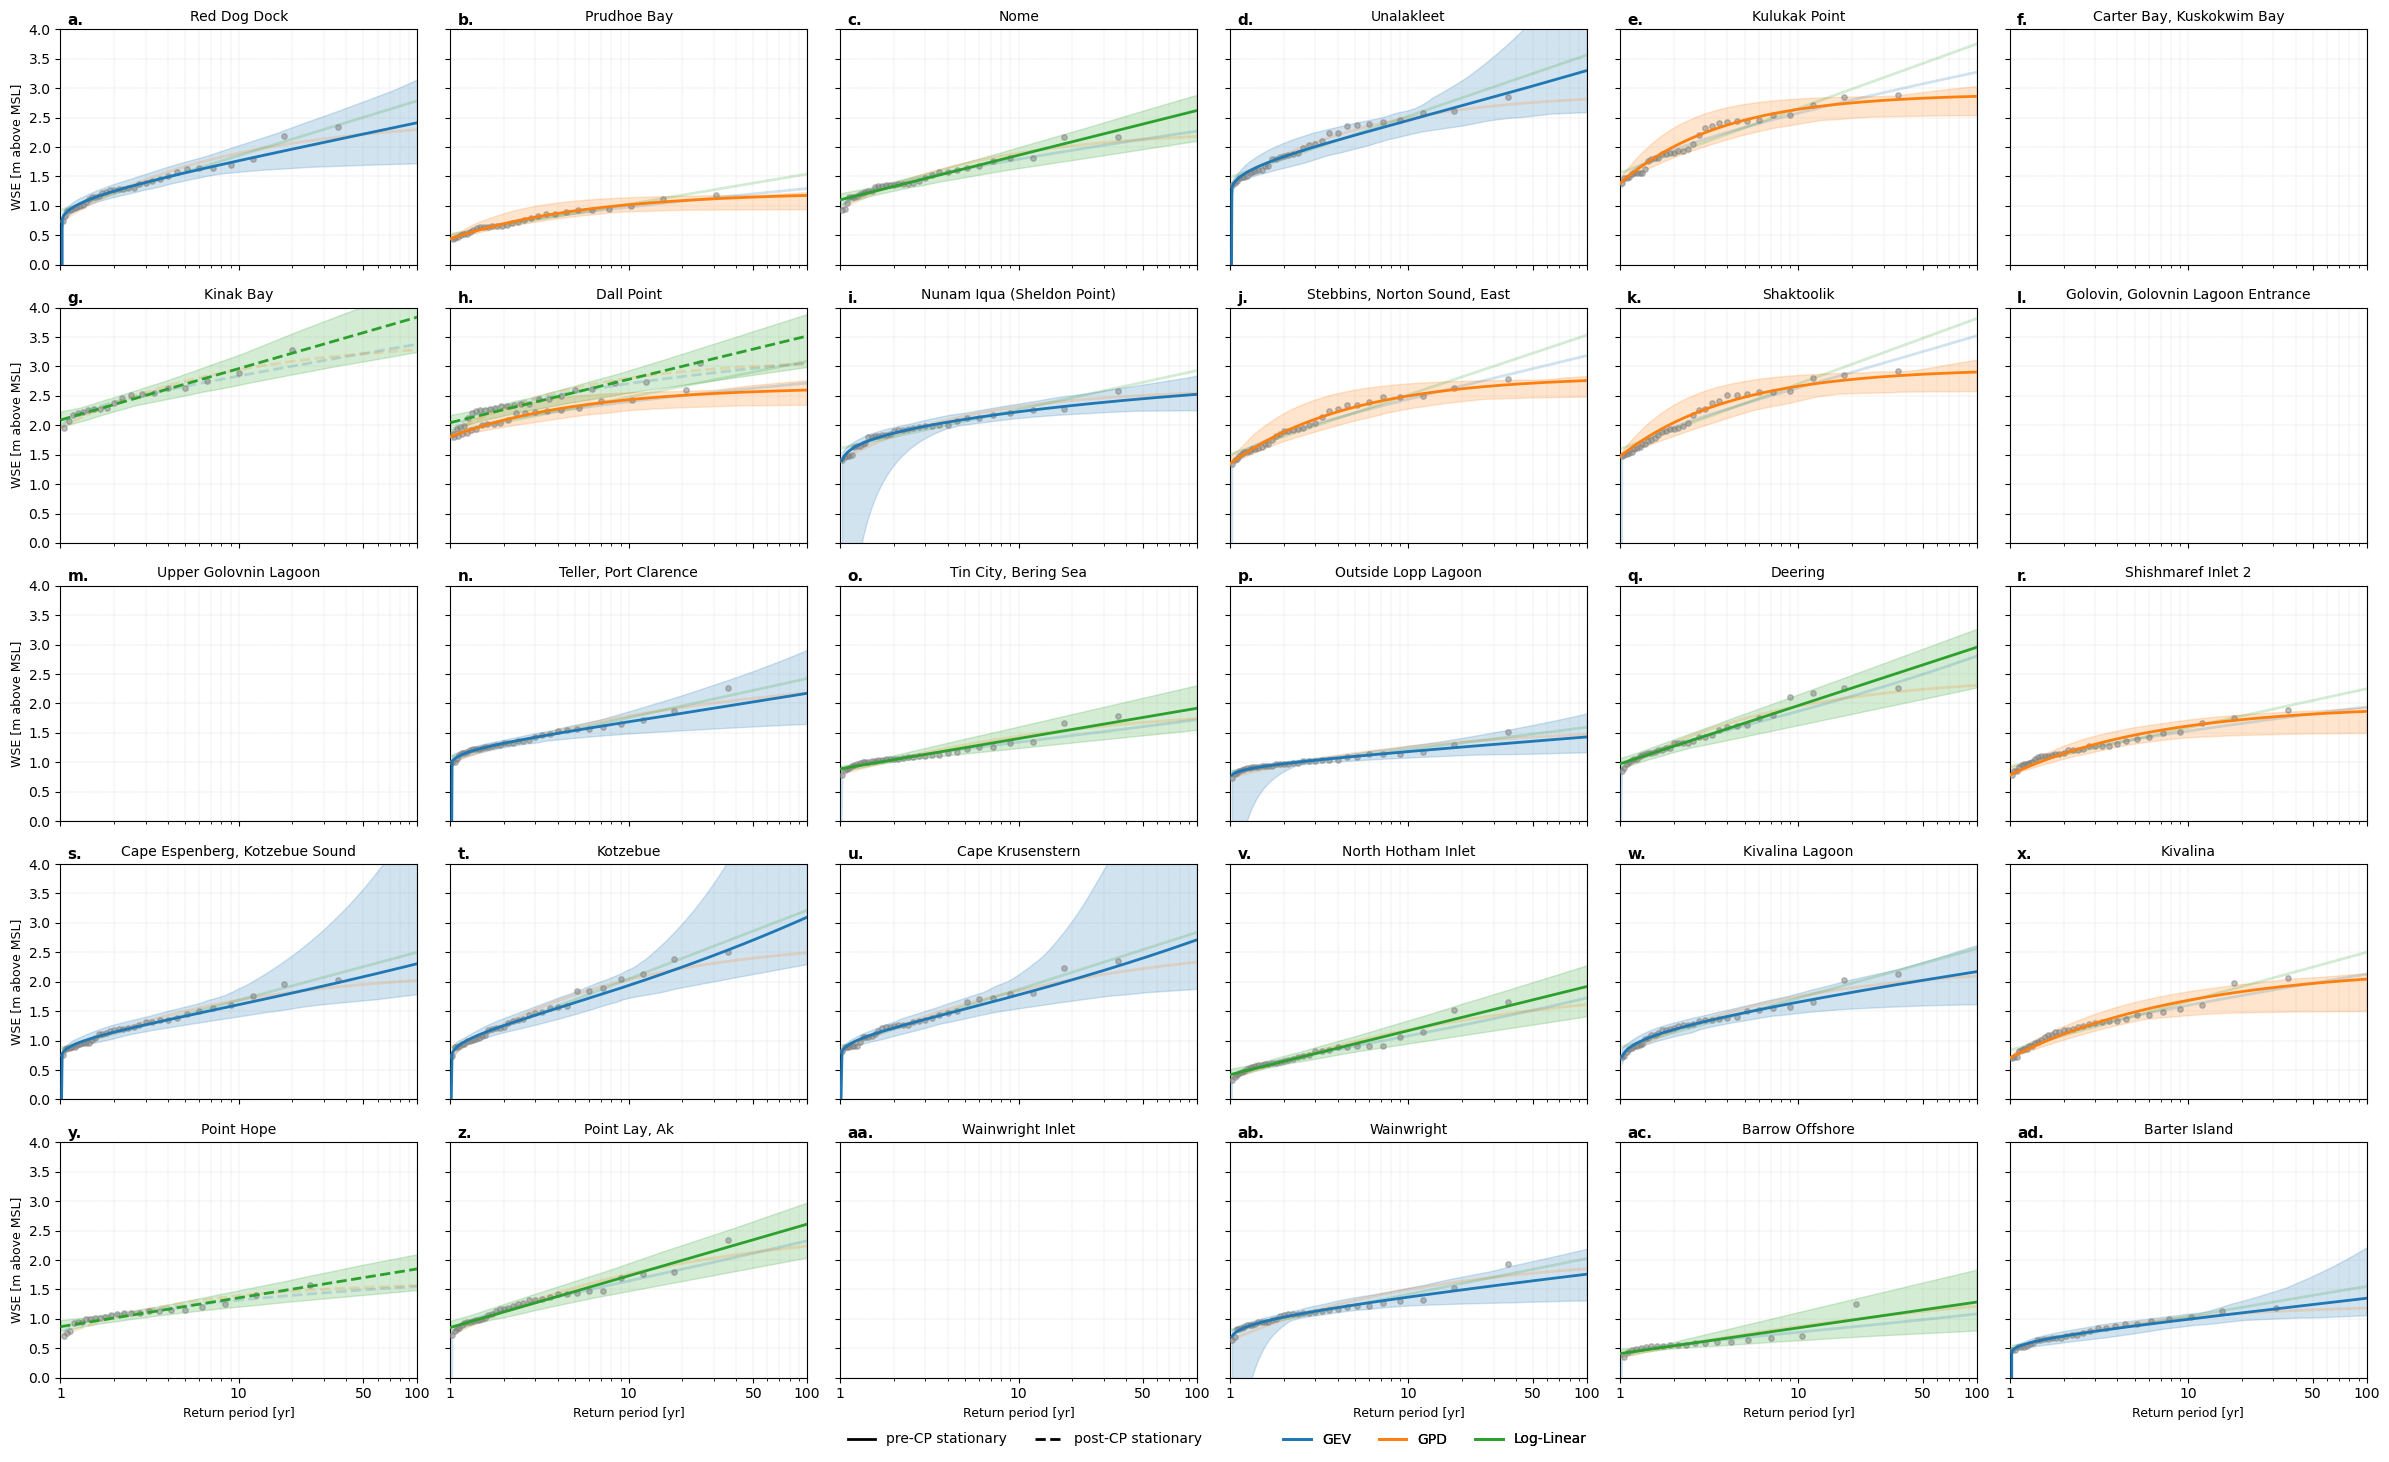

In [20]:
import ruptures as rpt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import genpareto, genextreme, anderson_ksamp, PermutationMethod
from matplotlib.lines import Line2D
from matplotlib.ticker import FixedLocator, FuncFormatter

# ─── assume years_int, comms_ordered, annual_max, and letters are already defined ─────────
alpha     = 0.05    # stationarity threshold
MIN_YEARS = 15      # minimum years for return-period

def is_stat(arr):
    """Return True if arr is stationary (ADF p<alpha and KPSS p>alpha)."""
    try:
        p_adf  = adfuller(arr, autolag='AIC')[1]
        p_kpss = kpss(arr, regression='c', nlags='auto')[1]
        return (p_adf < alpha) and (p_kpss > alpha)
    except:
        return False

def fit_curves(vals):
    """Fit GEV, GPD, LL to vals and return (T_emp, sorted_vals, gev, gpd, ll)."""
    sorted_vals = np.sort(vals)[::-1]
    N = len(sorted_vals)
    ranks = np.arange(1, N+1)
    T_emp = (N + 1) / ranks
    # GEV
    c, loc, sc = genextreme.fit(sorted_vals)
    gev = genextreme.ppf(1 - 1/T_plot, c, loc=loc, scale=sc)
    # GPD
    thr = sorted_vals.min()
    excess = sorted_vals - thr
    c2, loc2, sc2 = genpareto.fit(excess, floc=0)
    gpd = thr + genpareto.ppf(1 - 1/T_plot, c2, loc=0, scale=sc2)
    # Log-Linear
    a, b = np.polyfit(np.log(T_emp), sorted_vals, 1)
    ll = a * np.log(T_plot) + b
    return T_emp, sorted_vals, gev, gpd, ll

def bootstrap_ci(vals, dist, n_boot=100, alpha_ci=0.05):
    """
    Bootstrap to get 95% CI on return-level curve for distribution dist.
    dist ∈ {'GEV','GPD','LL'}. Returns (lower, upper) arrays.
    """
    N = len(vals)
    curves = []
    for _ in range(n_boot):
        sample = np.random.choice(vals, size=N, replace=True)
        sorted_s = np.sort(sample)[::-1]
        ranks_s = np.arange(1, N+1)
        T_emp_s = (N + 1) / ranks_s

        if dist == 'GEV':
            c_loc = genextreme.fit(sorted_s)
            curves.append(
                genextreme.ppf(1 - 1/T_plot, *c_loc)
            )
        elif dist == 'GPD':
            thr_s = sorted_s.min()
            exc_s = sorted_s - thr_s
            c2_loc2_sc2 = genpareto.fit(exc_s, floc=0)
            curves.append(
                thr_s + genpareto.ppf(1 - 1/T_plot, *c2_loc2_sc2)
            )
        else:  # 'LL'
            a_s, b_s = np.polyfit(np.log(T_emp_s), sorted_s, 1)
            curves.append(a_s * np.log(T_plot) + b_s)

    arr = np.vstack(curves)
    lower = np.percentile(arr, 100*(alpha_ci/2), axis=0)
    upper = np.percentile(arr, 100*(1 - alpha_ci/2), axis=0)
    return lower, upper

# return-period grid up to 100 years
T_plot = np.logspace(0, math.log10(100), 200)
ymax   = 4.0

# distribution colors
colors = {'GEV':'C0', 'GPD':'C1', 'LL':'C2'}

# prepare subplots
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True, sharey=True,
                         constrained_layout=False)
axes = axes.flatten()

for idx, comm in enumerate(comms_ordered):
    ax   = axes[idx]
    data = annual_max[comm]
    mask = ~np.isnan(data)
    x    = years_int[mask]
    y    = data[mask]

    if len(x) < 3:
        ax.set_title(comm.title(), fontsize=10)
        ax.axis('off')
        continue

    # 1) detect change-point
    algo   = rpt.Binseg(model="rbf").fit(y.reshape(-1,1))
    cp_idx = algo.predict(n_bkps=1)[0]
    has_cp = 0 < cp_idx < len(y)

    # 2) split pre- and post-segments
    pre_y  = y[:cp_idx]    if has_cp else y
    post_y = y[cp_idx:]    if has_cp else np.array([])

    # 3) stationarity + length check
    pre_stat  = (len(pre_y)  >= MIN_YEARS) and is_stat(pre_y)
    post_stat = (len(post_y) >= MIN_YEARS) and is_stat(post_y)

    # containers for fits
    best   = {}
    curves = {}

    # 4) fit & test each stationary segment
    for seg, seg_y in [('pre', pre_y), ('post', post_y)]:
        if not ((seg=='pre'  and pre_stat) or
                (seg=='post' and post_stat)):
            continue

        # fit to segment
        T_emp, vals, gev, gpd, ll = fit_curves(seg_y)
        # scatter empirical
        ax.scatter(T_emp, vals, color='gray', s=15, alpha=0.5, zorder=4)

        # Anderson–Darling p-values
        pvals = {}
        # GEV
        pvals['GEV'] = anderson_ksamp(
            [genextreme.cdf(vals, *genextreme.fit(vals)),
             np.random.rand(len(vals))],
            method=PermutationMethod()
        ).pvalue
        # GPD
        thr = vals.min()
        exc = vals - thr
        pvals['GPD'] = anderson_ksamp(
            [genpareto.cdf(exc, *genpareto.fit(exc, floc=0)),
             np.random.rand(len(vals))],
            method=PermutationMethod()
        ).pvalue
        # LL
        a, b = np.polyfit(np.log(T_emp), vals, 1)
        pred_ll = a * np.log(T_emp) + b
        pvals['LL'] = anderson_ksamp(
            [vals, pred_ll],
            method=PermutationMethod()
        ).pvalue

        # pick best distribution
        best_dist = max(pvals, key=pvals.get)
        best[seg] = best_dist
        curves[seg] = {'GEV':gev, 'GPD':gpd, 'LL':ll}

    # 5) plot stationary-segment curves & CI
    for seg, ls in [('pre','-'), ('post','--')]:
        if seg not in best:
            continue
        seg_y = pre_y if seg=='pre' else post_y
        for dist in ['GEV','GPD','LL']:
            curve = curves[seg][dist]
            is_best = (dist == best[seg])
            alpha_line = 1.0 if is_best else 0.2
            ax.plot(T_plot, curve,
                    color=colors[dist],
                    linestyle=ls,
                    linewidth=2,
                    alpha=alpha_line,
                    zorder=(5 if is_best else 3))
            if is_best:
                # compute 95% bootstrap CI
                lower, upper = bootstrap_ci(seg_y, dist, n_boot=100, alpha_ci=0.05)
                ax.fill_between(T_plot, lower, upper,
                                color=colors[dist],
                                alpha=0.2,
                                zorder=2)

    # 6) formatting
    ax.set_xscale('log')
    ax.set_xlim(1, 100)
    ax.set_ylim(0, ymax)
    xticks = [1, 10, 50, 100]
    ax.xaxis.set_major_locator(FixedLocator(xticks))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda t,pos: f"{int(t)}"))
    ax.set_title(comm.title(), fontsize=10)

    if idx % ncols == 0:
        ax.set_ylabel("WSE [m above MSL]", fontsize=9)
    else:
        ax.tick_params(labelleft=False)

    if idx // ncols == nrows - 1:
        ax.set_xlabel("Return period [yr]", fontsize=9)

    ax.text(0.02, 1.02, letters[idx],
            transform=ax.transAxes,
            fontsize=11, weight='bold', clip_on=False)

    ax.grid(True, linestyle=':', linewidth=0.3, which='both')

# 7) hide unused panels
for ax in axes[n:]:
    ax.axis('off')

# 8) legends
dist_handles = [Line2D([0],[0], color=colors[d], lw=2) for d in ['GEV','GPD','LL']]
dist_labels  = ['GEV','GPD','Log-Linear']
seg_handles  = [Line2D([0],[0], color='k', lw=2, ls='-'),
                Line2D([0],[0], color='k', lw=2, ls='--')]
seg_labels   = [f'pre-CP stationary',
                f'post-CP stationary']
leg1 = fig.legend(dist_handles, dist_labels,
                  loc='upper center',
                  bbox_to_anchor=(0.6,0.04), ncol=3, frameon=False)
leg2 = fig.legend(seg_handles, seg_labels,
                  loc='upper left',
                  bbox_to_anchor=(0.35,0.04),ncol=2, frameon=False)
fig.add_artist(leg1)

# 9) tighten spacing & save
plt.subplots_adjust(left=0.05, right=0.99,
                    top=0.96, bottom=0.06,
                    wspace=0.02, hspace=0.04)
plt.tight_layout(rect=[0,0.03,1,0.99])

plt.savefig(
    '/scratch/tmiesse/project/figures/return_periods_stat_segments.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [15]:
years_int = np.array([int(y) for y in years])
N_years   = len(years_int)

# build a dict of all 90th‑pct peaks per station (flatten across years)
peaks_90 = {
    comm: np.concatenate([
        monthly_data[comm][yr]['zeta_peaks_90th']
        for yr in years
        if monthly_data[comm][yr]['zeta_peaks_90th']
    ]) 
    for comm in comms_ordered
}


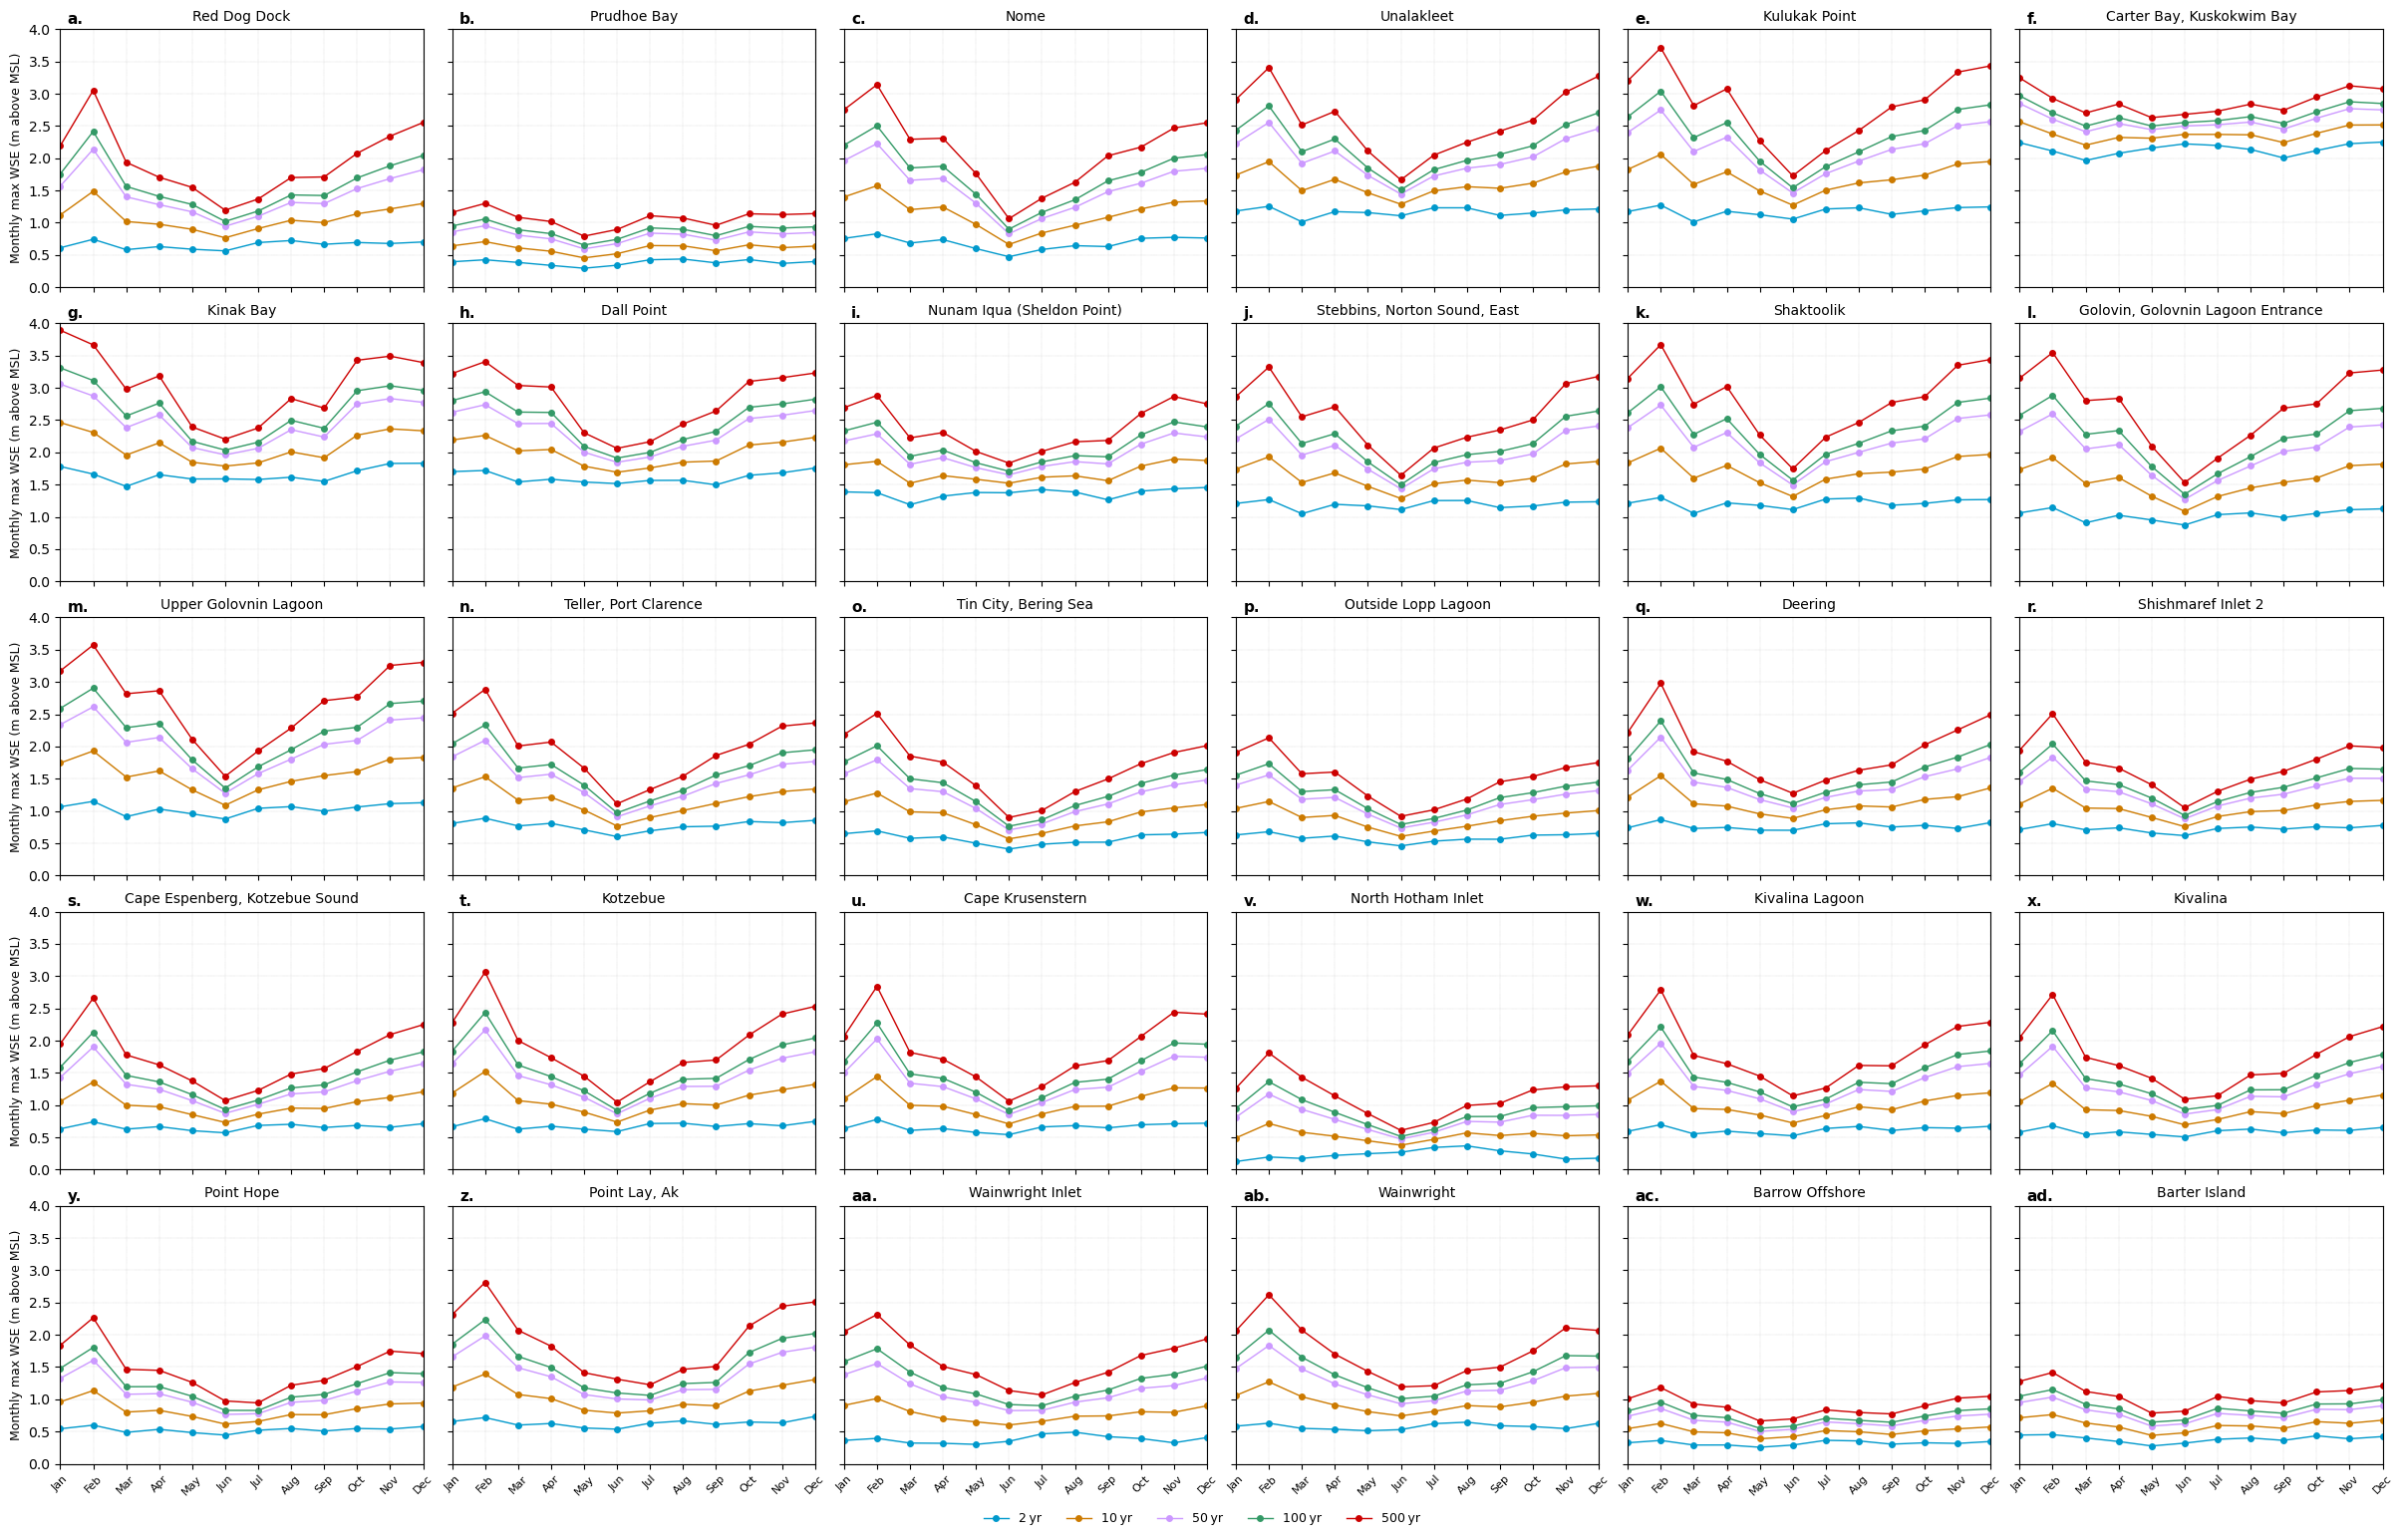

In [16]:
from scipy.stats import gumbel_r
monthly_by_month = {
    comm: {
        m: np.array([
            monthly_data[comm][yr][m]['zeta_max']
            for yr in years
        ])
        for m in range(1, 13)
    }
    for comm in comms_ordered
}
colors         = ['#0099cc','#cc7a00','#cc99ff','#339966','#cc0000']
# define return periods and their exceedance probabilities
return_periods = [2, 10,50, 100, 500]
p_levels       = [1/r for r in return_periods]

months         = np.arange(1, 13)
month_names    = ['Jan','Feb','Mar','Apr','May','Jun',
                  'Jul','Aug','Sep','Oct','Nov','Dec']

# compute a common y‐limit based on all stations × months at the 500 yr level
levels_all = []
for comm in comms_ordered:
    for m in months:
        vals = monthly_by_month[comm][m]
        vals = vals[~np.isnan(vals)]
        if vals.size >= 3:
            params = gumbel_r.fit(vals)
            levels_all.append(gumbel_r.ppf(1 - p_levels[-1], *params))
ymax = 4#max(levels_all) * 1.05

# set up 30‐panel grid
n     = len(comms_ordered)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols,
                         figsize=(ncols*4, nrows*3),
                         sharex=True, constrained_layout=True)
axes = axes.flatten()

# loop and plot
for idx, comm in enumerate(comms_ordered):
    ax = axes[idx]
    for rp, p, col in zip(return_periods, p_levels, colors):
        q = []
        for m in months:
            vals = monthly_by_month[comm][m]
            vals = vals[~np.isnan(vals)]
            if vals.size >= 3:
                params = gumbel_r.fit(vals)
                q.append(gumbel_r.ppf(1 - p, *params))
            else:
                q.append(np.nan)
        ax.plot(months, q,
                marker='o', linestyle='-',
                color=col, label=f"{rp} yr",
                markersize=4, linewidth=1)

    # formatting
    ax.set_xlim(1, 12)
    ax.set_xticks(months)
    ax.set_xticklabels(month_names, rotation=45, fontsize=8)
    ax.set_ylim(0, ymax)
    ax.set_title(comm.title(), fontsize=10)
    if idx % ncols == 0:
        ax.set_ylabel("Monthly max WSE (m above MSL)", fontsize=9)
    else:
        ax.tick_params(labelleft=False)
    ax.text(0.02, 1.02, letters[idx],
            transform=ax.transAxes,
            fontsize=11, weight='bold', clip_on=False)
    ax.grid(True, linestyle=':', linewidth=0.3)

# hide any empty panels
for ax in axes[n:]:
    ax.axis('off')

# shared legend showing return‐period years
fig.legend(
    loc='upper center',
    ncol=len(return_periods),
    labels=[f"{rp} yr" for rp in return_periods],
    fontsize=9,
    frameon=False,
    bbox_to_anchor=(0.5, 0.0)
)

# save & show
fig.savefig(
    '/scratch/tmiesse/project/figures/seasonal_exceedance_returnperiods.png',
    dpi=300, bbox_inches='tight', pad_inches=0.1
)
plt.show()

In [27]:
rows = []
for comm in comms_ordered:
    row = {'community': comm.title()}
    # include 'max' for annual_max plus each percentile
    metrics = ['max'] + percentile_keys
    for m in metrics:
        if m == 'max':
            arr = annual_max[comm]
        else:
            arr = annual_pct[comm][m]
        valid = ~np.isnan(arr)
        if valid.sum() >= 2:
            # compute slope (m/yr) and MK stats
            slope, _ = np.polyfit(years_int[valid], arr[valid], 1)
            res = mk.original_test(arr[valid])
            row[m]               = slope * 1000
            row[f"tau {m}"]      = res.Tau
            row[f"pvalue {m}"]   = res.p
        else:
            # not enough data
            row[m]             = np.nan
            row[f"tau {m}"]    = np.nan
            row[f"pvalue {m}"] = np.nan
    rows.append(row)

# make DataFrame and reorder columns
df_wide = pd.DataFrame(rows)
cols = (
    ['community'] +
    ['max'] +
    percentile_keys +
    ['tau max'] +
    [f"tau {pk}" for pk in percentile_keys] +
    ['pvalue max'] +
    [f"pvalue {pk}" for pk in percentile_keys]
)
df_wide = df_wide[cols]

# save to CSV
output_csv = '/scratch/tmiesse/project/all_trends_stats_wide.csv'
df_wide.to_csv(output_csv, index=False)
print(f"Saved wide-format trends to {output_csv}")

Saved wide-format trends to /scratch/tmiesse/project/all_trends_stats_wide.csv


In [7]:
comms_ordered = [
    'red dog dock','prudhoe bay','nome','unalakleet',
    'kulukak point','carter bay, kuskokwim bay','kinak bay','dall point',
    'nunam iqua (sheldon point)','stebbins, norton sound, east','shaktoolik',
    'golovin, golovnin lagoon entrance','upper golovnin lagoon',
    'teller, port clarence','tin city, bering sea','outside lopp lagoon',
    'deering','shishmaref inlet 2','cape espenberg, kotzebue sound',
    'kotzebue','cape krusenstern','north hotham inlet','kivalina lagoon',
    'kivalina','point hope','point lay, ak','wainwright inlet','wainwright',
    'barrow offshore','barter island'
]
def decode_comms(raw):
    return [
        v.tobytes().decode('ascii').rstrip('\x00').strip().lower()
        for v in raw
    ]

def pct_label(p):
    s = f"{p*100:.3f}".rstrip('0').rstrip('.')
    return f"{s}th"

# ─── 1) Discover communities & read time coord per year ───────────────────────
with nc4.Dataset(str(root / f"{years[0]}.nc")) as ds0:
    raw_comms = ds0.variables['community'][:]    # byte strings
    comms     = decode_comms(raw_comms)
    lats      = ds0.variables['lat'][:]         # array of floats
    lons      = ds0.variables['lon'][:]

lat_map = {comms[i]: float(lats[i]) for i in range(len(comms))}
lon_map = {comms[i]: float(lons[i]) for i in range(len(comms))}

unique_comms = comms  # from first file

time_year = {}
for yr in years:
    with nc4.Dataset(str(root / f"{yr}.nc")) as ds:
        tvar = ds.variables['time']
        time_year[yr] = nc4.num2date(
            tvar[:], tvar.units, getattr(tvar, 'calendar', 'standard')
        )
years_int = np.array([int(y) for y in years])
rates     = {comm: {} for comm in comms_ordered}

for comm in comms_ordered:
    max_vals  = np.array([monthly_data[comm][yr]['yearly_max_zeta'] for yr in years], dtype=float)
    pct99_v   = np.array([monthly_data[comm][yr]['zeta_annual_percentiles']['99th'] for yr in years], dtype=float)
    pct95_v   = np.array([monthly_data[comm][yr]['zeta_annual_percentiles']['95th'] for yr in years], dtype=float)
    pct90_v   = np.array([monthly_data[comm][yr]['zeta_annual_percentiles']['90th'] for yr in years], dtype=float)

    for label, series in [('max', max_vals), ('99th', pct99_v),('95th', pct95_v), ('90th', pct90_v)]:
        mask = ~np.isnan(series)
        if mask.sum() >= 2:
            slope, _ = np.polyfit(years_int[mask], series[mask], 1)
            rates[comm][label] = slope * 1000  # in mm/yr
        else:
            rates[comm][label] = np.nan

    # attach coordinates
    rates[comm]['lat'] = lat_map[comm]
    rates[comm]['lon'] = lon_map[comm]

/tmp/ipykernel_2987988/1806185756.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm', n_classes)
/tmp/ipykernel_2987988/1806185756.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm', n_classes)
/tmp/ipykernel_2987988/1806185756.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm', n_classes)
/tmp/ipykernel_2987988/1806185756.py:51: MatplotlibDeprecationWarni

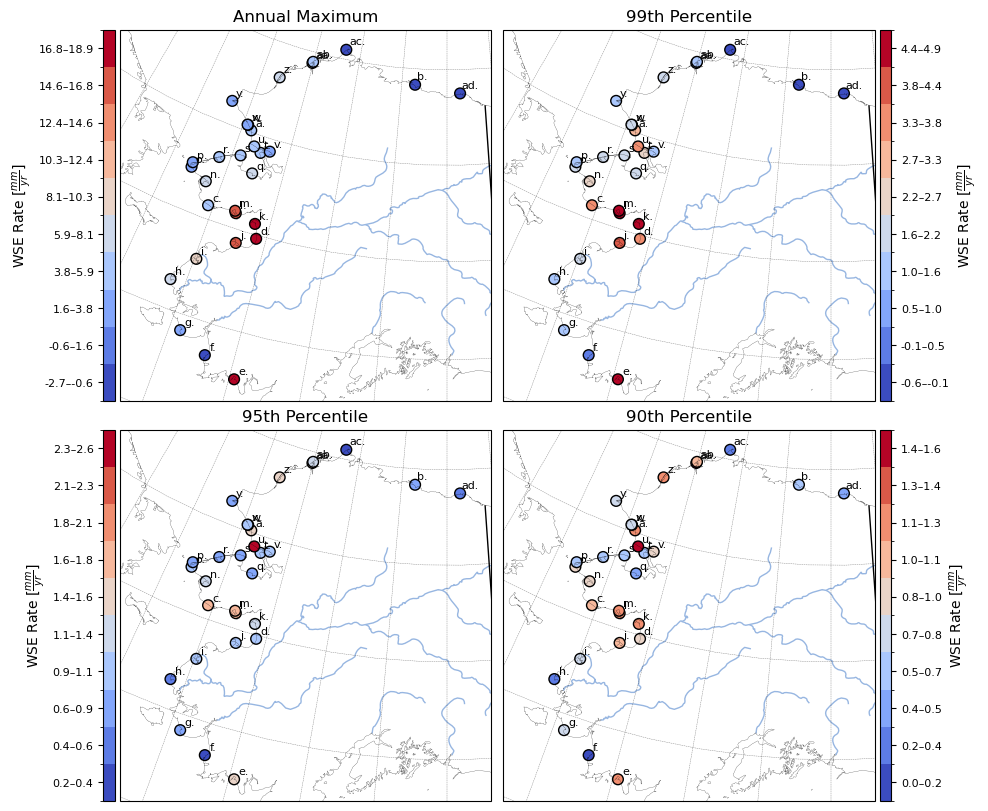

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
proj = ccrs.NorthPolarStereo(central_longitude=-145)
lat1, lat2 = 59, 71
lon1, lon2 = -168, -142

# ─── Metrics to plot ───────────────────────────────────────────────────────────
metrics = [
    ('max',  r'Annual Maximum'),
    ('99th', r'99th Percentile'),
    ('95th', r'95th Percentile'),
    ('90th', r'90th Percentile'),
]


n_classes = 10

# ─── (User must define these beforehand) ────────────────────────────────────────
# rates: dict, keys = community names, values = {'lon': float, 'lat': float, 'max':…, '99th':…, …}
# comms_ordered: list of community names, in the order you want to plot
# letters:      list of single‑letter labels, same length as comms_ordered

# ─── Create figure and 2×2 axes ────────────────────────────────────────────────
fig, axes = plt.subplots(
    2, 2, figsize=(8, 8),
    subplot_kw={'projection': proj},
    constrained_layout=True
)
axes_flat = axes.flatten()

# ─── Loop over panels ─────────────────────────────────────────────────────────
for idx, (ax, (key, title)) in enumerate(zip(axes_flat, metrics)):
    # Base map
    ax.set_extent([lon1, lon2, lat1, lat2], crs=cart.crs.PlateCarree())
    ax.coastlines(resolution='10m', linewidth=0.15)
    ax.add_feature(cart.feature.RIVERS, linestyle='-')
    ax.add_feature(cart.feature.BORDERS.with_scale('50m'), linestyle='-')
    ax.gridlines(
        xlocs=np.arange(-190, -100, 5),
        ylocs=np.arange(-90,   90,   3.5),
        draw_labels=False,
        linewidth=0.3, color='black',
        alpha=0.5, y_inline=False,
        linestyle='--', zorder=20
    )

    # Extract, bin and normalize
    vals = np.array([rates[c][key] for c in comms_ordered], dtype=float)
    mask = ~np.isnan(vals)
    vmin, vmax = vals[mask].min(), vals[mask].max()
    boundaries = np.linspace(vmin, vmax, n_classes + 1)
    cmap = mpl.cm.get_cmap('coolwarm', n_classes)
    norm = mpl.colors.BoundaryNorm(boundaries, ncolors=n_classes, clip=True)

    # Scatter points
    lons = [rates[c]['lon'] for c in comms_ordered]
    lats = [rates[c]['lat'] for c in comms_ordered]
    sc = ax.scatter(
        lons, lats,
        c=vals, cmap=cmap, norm=norm,
        s=60, edgecolor='k',
        transform=cart.crs.PlateCarree()
    )

    # Label each point
    for j, comm in enumerate(comms_ordered):
        ax.text(
            rates[comm]['lon'] + 0.2,
            rates[comm]['lat'] + 0.2,
            letters[j],
            transform=cart.crs.PlateCarree(),
            fontsize=8, fontweight=None, color='k'
        )

    ax.set_title(title, fontsize=12)

    # Colorbar: left for left‑column (idx 0 & 2), right for right‑column (idx 1 & 3)
    divider = make_axes_locatable(ax)
    if idx % 2 == 0:
        cax = divider.append_axes('left',  size='3%', pad=0.05, axes_class=plt.Axes)
    else:
        cax = divider.append_axes('right', size='3%', pad=0.05, axes_class=plt.Axes)

    cbar = fig.colorbar(
        sc, cax=cax, orientation='vertical',
        ticks=(boundaries[:-1] + boundaries[1:]) / 2
    )
    # Put ticks, ticklabels, and label on correct side
    if idx % 2 == 0:
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.ax.yaxis.tick_left()
    else:
        cbar.ax.yaxis.set_ticks_position('right')
        cbar.ax.yaxis.set_label_position('right')
        cbar.ax.yaxis.tick_right()

    ticklabels = [
        f"{boundaries[i]:.1f}–{boundaries[i+1]:.1f}"
        for i in range(len(boundaries)-1)
    ]
    cbar.set_ticklabels(ticklabels, fontsize=8)
    cbar.set_label(r'WSE Rate $[\frac{mm}{yr}]$', fontsize=10)
plt.savefig('/scratch/tmiesse/project/figures/trend_maps.png',
            dpi=480, bbox_inches='tight', pad_inches=0.1, transparent=False)
# Show plot
plt.show()